In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from netCDF4 import Dataset
import numpy as np
import os
from matplotlib.gridspec import GridSpec
from scipy.stats import mannwhitneyu
import sys

sys.path.insert(0, ''+'/Code/Code_ACP_article/data-objekt')
from Data_object import Data, load
from Utility import calc_ED


In [2]:
path = ''+'/Data/Data_ACP_article/Trajectory_data/'

In [3]:
file_all = os.listdir(path)
file = [x for x in file_all if 'combined' in x and 'v2' in x][0]

data = pd.read_parquet(path+ '/' + file)

In [4]:
# Remove convection flights
campaign = data.loc[~((data.index >= pd.Timestamp(2021,7,8))&(data.index < pd.Timestamp(2021,7,9)) |
                  (data.index >= pd.Timestamp(2021,7,13))&(data.index < pd.Timestamp(2021,7,14)))]

In [41]:
file_tray = [x for x in file_all if 'alltrajec' in x and 'v2' in x][0]

data_raw_tray = pd.read_parquet(path+ '/' + file_tray)

In [28]:
data_raw_tray

,lon,lat,p,Q,LWC,IWC,RWC,SWC,RH,RHI,T,TH,PV,OMEGA,n
time,,,,,,,,,,,,,,,
0.0,11.28,48.08,941.02,9.062,0.000,0.0,1.763,0.0,70.577,70.577,16.918,295.158,-0.682,-0.079,1.0
-1.0,11.08,48.09,942.42,8.780,0.000,0.0,0.173,0.0,70.259,70.259,16.511,294.619,-1.166,0.004,1.0
-2.0,10.82,48.10,938.90,7.814,0.000,0.0,9.455,0.0,65.912,65.912,15.649,294.058,-0.985,0.162,1.0
-3.0,10.52,48.09,934.57,8.388,0.000,0.0,7.099,0.0,77.235,77.235,14.212,292.981,-0.827,0.099,1.0
-4.0,10.23,48.04,931.68,8.817,0.014,0.0,5.358,0.0,88.003,88.003,12.939,291.939,-0.376,0.052,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-236.0,2.53,44.17,688.75,1.296,0.000,0.0,0.000,0.0,14.141,14.141,7.040,311.729,0.479,-0.162,45496.0
-237.0,2.70,44.40,694.67,1.298,0.299,0.0,0.000,0.0,14.058,14.058,7.287,311.248,0.720,-0.093,45496.0
-238.0,2.92,44.58,700.99,1.180,0.000,0.0,0.000,0.0,11.836,11.836,8.560,311.847,0.611,-0.190,45496.0


In [19]:
direct_ext = ''+'/Data/Data_ACP_article/Extinction/'
for i, file in enumerate(os.listdir(direct_ext)):
    if 'parquet' in file:
        if i == 0:
            ext_data = pd.read_parquet(direct_ext + file)
        else:
            ext_data = pd.concat([ext_data, pd.read_parquet(direct_ext + file)])

In [20]:
indexes = []
for i in range(len(ext_data)):
    if ext_data.index[i] in campaign.index:
        indexes.append(True)
    else:
        indexes.append(False)

In [21]:
campaign['Ext'] = ext_data[indexes]

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
file_NOy = ''+'/Data/Data_ACP_article/Trajectory_data/NO_alldata.parquet'
NOy = pd.read_parquet(file_NOy)

In [30]:
NOy

,NO,NOy
UTC,,
2021-06-25 11:03:44,0.4930,2.4730
2021-06-25 11:03:46,0.4820,2.4655
2021-06-25 11:03:48,0.4670,2.4290
2021-06-25 11:03:50,0.4525,2.3990
2021-06-25 11:03:52,0.4415,2.3795
...,...,...
2021-07-28 17:36:42,0.0510,2.5150
2021-07-28 17:36:44,0.0510,2.5250
2021-07-28 17:36:46,0.0505,2.5080


In [11]:
NOy[NOy.NO == 99999] = np.NAN
NOy[NOy.NOy == 99999] = np.NAN

In [12]:
NOy = NOy.resample('2S').mean()

In [13]:
campaign['NO'] = np.NAN
campaign['NOy'] = np.NAN

In [14]:
for i, ind in enumerate(NOy.index):
    if ind in campaign.index:
        campaign['NO'].loc[ind] = NOy.NO.loc[ind]
        campaign['NOy'].loc[ind] = NOy.NOy.loc[ind]

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
def iwc_to_ISunits(iwc, p, T):
    iwc_is = iwc*p/(287.05*(T+273.15))*1e-4
    return iwc_is

In [15]:
def updraft_to_ISunits(omega, p, T):
    # p in hPa as input
    # T in °C as input
    w_up = -omega*287.058*(T+273.15)/(p*9.80665*100)
    return w_up

In [16]:
data_raw_tray['w_up'] = updraft_to_ISunits(data_raw_tray.OMEGA, data_raw_tray.p, data_raw_tray['T'])*100 #to cm/s

In [17]:
# Updraft Analysis

updraft_means = np.zeros((len(campaign), 2))
updraft_stds = np.zeros(len(campaign))

for i, index in enumerate(campaign.n):
    
    seq = data_raw_tray[data_raw_tray.n == index]
    pos = int(campaign[campaign.n == index].duration.iloc[0]+1)
    updraft_means[i, 0] = np.mean(seq.iloc[:pos].w_up)
    updraft_means[i, 1] = seq.iloc[pos-1].w_up
    updraft_stds[i] = np.std(seq.iloc[:pos].w_up)
    

In [18]:
campaign['upw_mean'] = updraft_means[:, 0]*100 # to cm s-1
campaign['upw_std'] = updraft_stds[:]*100 # to cm s-1
campaign['updraft_form'] = updraft_means[:, 1]*100 # to cm s-1

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [19]:
campaign['updraft_is'] = campaign['updraft_is'] * 100 
campaign['N_0_is'] = campaign['N_0_is'] * 1e-6
campaign.IWC_0_is = campaign.IWC_0_is * 1e3
campaign.ED_0_is = campaign.ED_0_is *1e6
campaign = campaign.loc[(campaign.N_0_is > 0) & (campaign.IWC_0_is > 0) & (campaign.ED_0_is>0)]

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [20]:
campaign.loc[:, 'Day'] = campaign.index.floor('D')

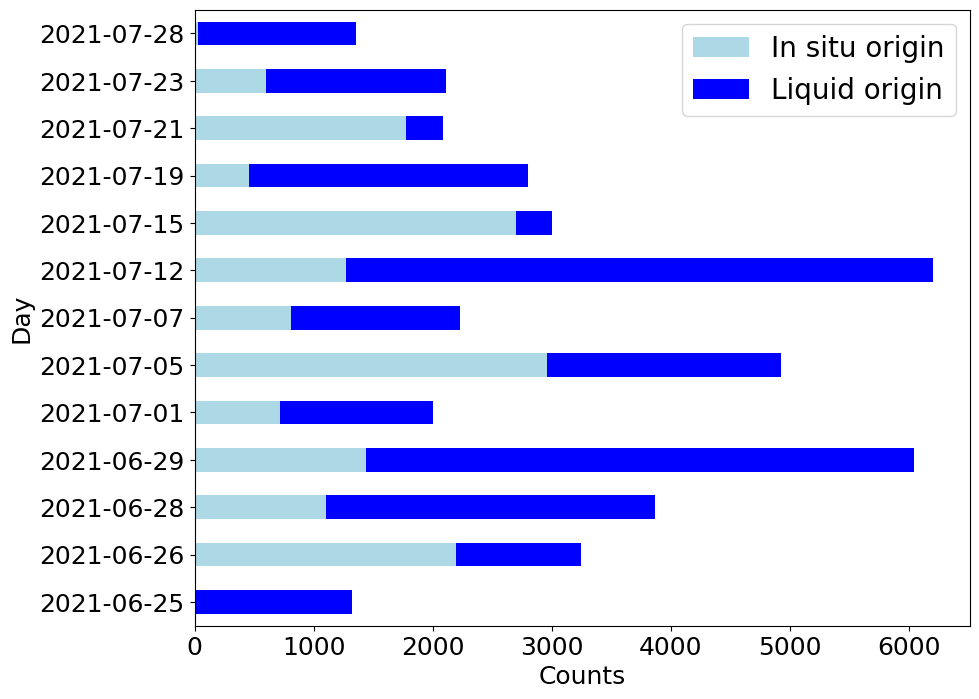

In [21]:
selecliq = campaign.loc[(campaign.N_0_is > 1e-6)&(campaign.ED_0_is > 3)&(campaign.type==0)]
liq = selecliq['Day'].value_counts()
selecis = campaign.loc[(campaign.N_0_is > 1e-6)&(campaign.ED_0_is > 3)&(campaign.type==1)]
ins = selecis['Day'].value_counts()
df_plot = pd.DataFrame({'In situ origin': ins, 'Liquid origin':liq}, index=campaign.groupby('Day').mean().index)
df_plot.index = df_plot.index.strftime('%Y-%m-%d')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
df_plot.plot(kind='barh', ax= ax, stacked='True', color=['lightblue', 'blue'], fontsize=18, )
plt.ylabel('Day', fontsize=18)
plt.xlabel('Counts', fontsize=18)
plt.legend(fontsize=20)

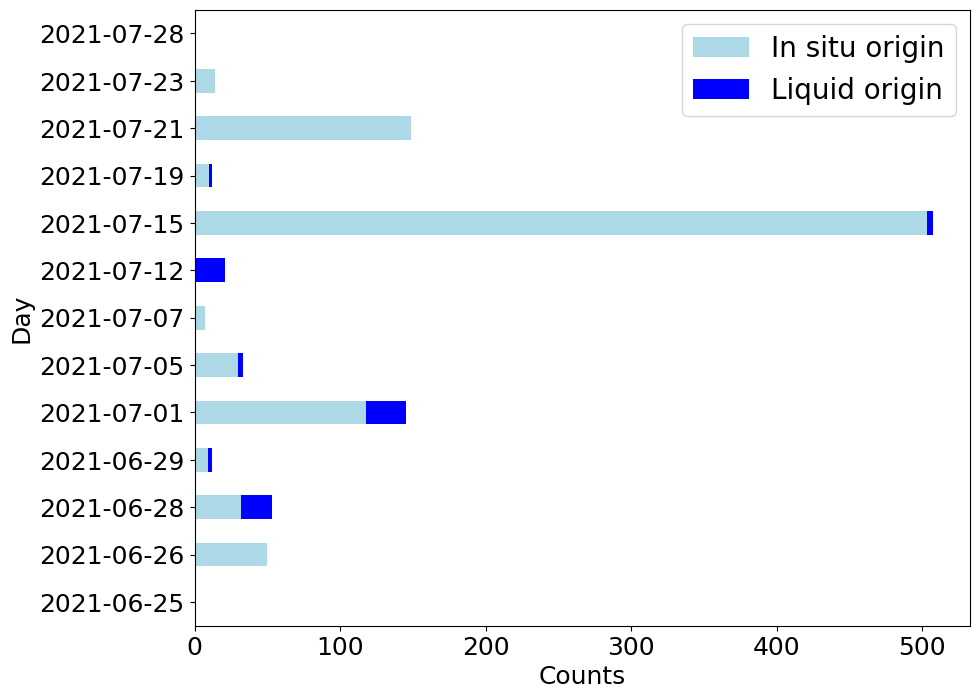

In [22]:
selecliq = campaign.loc[(campaign.N_0_is > 1e-1)&(campaign.ED_0_is < 40)&(campaign.type==0)&(campaign.altitude>8000)]
liq = selecliq['Day'].value_counts()
selecis = campaign.loc[(campaign.N_0_is > 1e-1)&(campaign.ED_0_is < 40)&(campaign.type==1)&(campaign.altitude>8000)]
ins = selecis['Day'].value_counts()
df_plot = pd.DataFrame({'In situ origin': ins, 'Liquid origin':liq}, index=campaign.groupby('Day').mean().index)
df_plot.index = df_plot.index.strftime('%Y-%m-%d')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
df_plot.plot(kind='barh', ax=ax, stacked='True', color=['lightblue', 'blue'], fontsize=18, )
plt.ylabel('Day', fontsize=18)
plt.xlabel('Counts', fontsize=18)
plt.legend(fontsize=20)

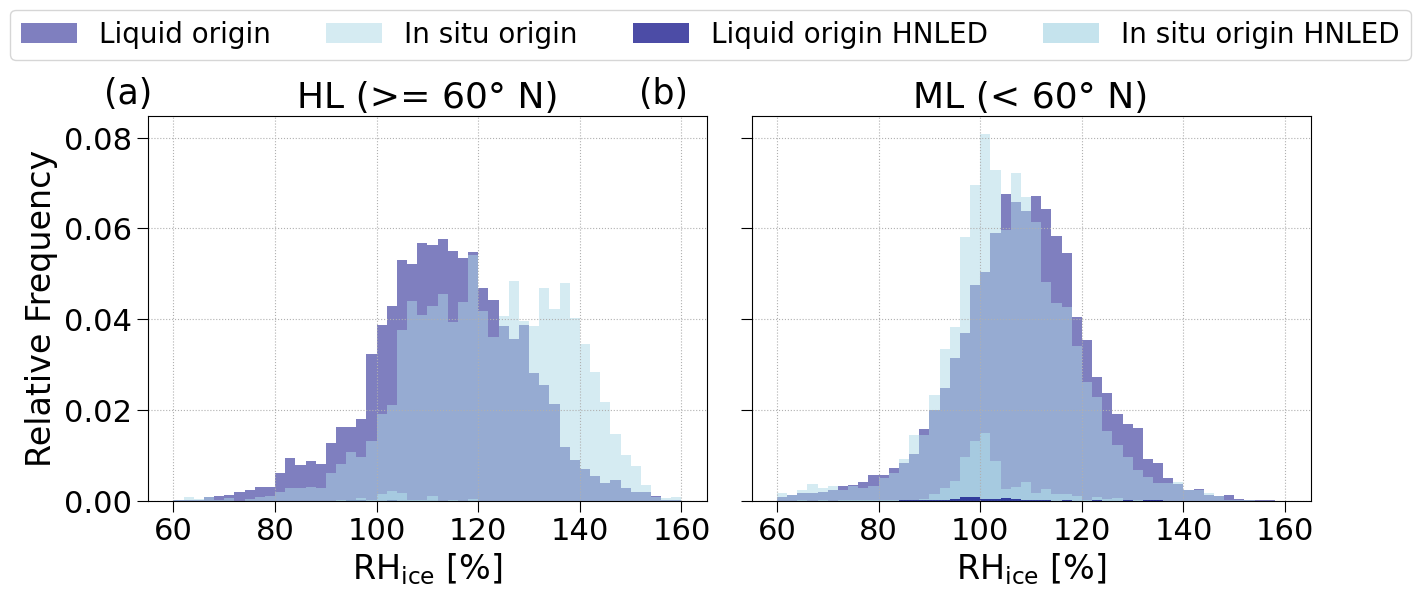

In [23]:
HL_liq = campaign[(campaign.type==0)&(campaign.lat_o_is >= 60)].RH_ice
HL_insitu = campaign[(campaign.type==1)&(campaign.lat_o_is >= 60)].RH_ice
ML_liq = campaign[(campaign.type==0)&(campaign.lat_o_is < 60)].RH_ice
ML_insitu = campaign[(campaign.type==1)&(campaign.lat_o_is < 60)].RH_ice

HL_liq_c = campaign[(campaign.type==0)&(campaign.lat_o_is >= 60)&(campaign.N_0_is > 1e-1)&(campaign.ED_0_is < 40)&(campaign.altitude>8000)].RH_ice
HL_insitu_c = campaign[(campaign.type==1)&(campaign.lat_o_is >= 60)&(campaign.N_0_is > 1e-1)&(campaign.ED_0_is < 40)&(campaign.altitude>8000)].RH_ice
ML_liq_c = campaign[(campaign.type==0)&(campaign.lat_o_is < 60)&(campaign.N_0_is > 1e-1)&(campaign.ED_0_is < 40)&(campaign.altitude>8000)].RH_ice
ML_insitu_c = campaign[(campaign.type==1)&(campaign.lat_o_is < 60)&(campaign.N_0_is > 1e-1)&(campaign.ED_0_is < 40)&(campaign.altitude>8000)].RH_ice

w_bin = 2

bins = np.arange(60, 161, w_bin)
mbins = (bins[1:] + bins[:-1])/2

fig = plt.figure(figsize=(15,5))
gs = GridSpec(1,2, hspace=0.25, wspace=0.08)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)


#hdata = HL_liq.hist(ax=ax1, bins=bins, color='navy', density=True, alpha=.5, label='Liquid origin')
#HL_insitu.hist(ax=ax1, bins=bins, color='lightblue', density=True, alpha=.5, label='In situ origin')

#ML_liq.hist(ax=ax2, bins=bins, color='navy', density=True, alpha=.5)
#ML_insitu.hist(ax=ax2, bins=bins, color='lightblue', density=True, alpha=.5)

h_hlliq, bins = np.histogram(HL_liq_c, bins=bins)
h_hlinsitu, bins = np.histogram(HL_insitu_c, bins=bins)
h_mlliq, bins = np.histogram(ML_liq_c, bins=bins)
h_mlinsitu, bins = np.histogram(ML_insitu_c, bins=bins)

H_hlliq, bins = np.histogram(HL_liq, bins=bins)
H_hlinsitu, bins = np.histogram(HL_insitu, bins=bins)
H_mlliq, bins = np.histogram(ML_liq, bins=bins)
H_mlinsitu, bins = np.histogram(ML_insitu, bins=bins)

h_hlliq = h_hlliq/H_hlliq.sum()
h_hlinsitu = h_hlinsitu/H_hlinsitu.sum()
h_mlliq = h_mlliq/H_mlliq.sum()
h_mlinsitu = h_mlinsitu/H_mlinsitu.sum()

H_hlliq = H_hlliq/H_hlliq.sum()
H_hlinsitu = H_hlinsitu/H_hlinsitu.sum()
H_mlliq = H_mlliq/H_mlliq.sum()
H_mlinsitu = H_mlinsitu/H_mlinsitu.sum()

ax1.grid(zorder=0, linestyle = "dotted")
ax2.grid(zorder=0, linestyle = "dotted")

ax1.bar(mbins, H_hlliq, width=w_bin, color='navy', alpha=0.5, label='Liquid origin')
ax1.bar(mbins, H_hlinsitu, width=w_bin, color='lightblue', alpha=0.5, label='In situ origin')

ax2.bar(mbins, H_mlliq, width=w_bin, color='navy', alpha=0.5)
ax2.bar(mbins, H_mlinsitu, width=w_bin, color='lightblue', alpha=0.5)


ax1.bar(mbins, h_hlliq, width=w_bin, color='navy', alpha=0.7, label='Liquid origin HNLED')
ax1.bar(mbins, h_hlinsitu, width=w_bin, color='lightblue', alpha=0.7, label='In situ origin HNLED')

ax2.bar(mbins, h_mlinsitu, width=w_bin, color='lightblue', alpha=0.7)
ax2.bar(mbins, h_mlliq, width=w_bin, color='navy', alpha=0.7)


plt.setp(ax2.get_yticklabels(), visible=False)

ax1.set_ylabel('Relative Frequency', fontsize=24)
ax1.set_xlabel(r'$\mathrm{RH_{ice}}$ [%]', fontsize=24)
ax2.set_xlabel(r'$\mathrm{RH_{ice}}$ [%]', fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=22, length=8)
ax2.tick_params(axis='both', which='major', labelsize=22, length=8)

ax1.set_title('HL (>= 60° N)', fontsize=26)
ax2.set_title('ML (< 60° N)', fontsize=26)

handles, labels = ax1.get_legend_handles_labels()
#handles.append(custom)
#labels.append('Median')

ax1.annotate('(a)', xy=(75, 355), xycoords='figure points', fontsize=25)
ax2.annotate('(b)', xy=(460, 355), xycoords='figure points', fontsize=25)

fig.legend(handles, labels, bbox_to_anchor=(0.5,1.12), loc='upper center', fontsize=20, ncol=4)

In [24]:
liqML = campaign.loc[(campaign.type==0)&(campaign.lat_o_is < 60)]
liqHL = campaign.loc[(campaign.type==0)&(campaign.lat_o_is >= 60)]
insML = campaign.loc[(campaign.type==1)&(campaign.lat_o_is < 60)]
insHL = campaign.loc[(campaign.type==1)&(campaign.lat_o_is >= 60)]
df_auxliqHL = liqHL.groupby(['n']).mean()
df_auxinsHL = insHL.groupby(['n']).mean()
df_auxliqML = liqML.groupby(['n']).mean()
df_auxinsML = insML.groupby(['n']).mean()

upw_liqHL = []
list_alt = []
list_time = []
max_w_liqHL = []

for i, ind in enumerate(df_auxliqHL.index):
    pos = int(liqHL[liqHL.n == ind].duration[0])+1
    N = liqHL[liqHL.n == ind].N_0_is.mean()
    typ = liqHL[liqHL.n == ind].type[0]
    marker = ['x' if typ == 1 else 'o']
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    time = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].index
    alt = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].p
    
    max_w_liqHL.append(max(updraft))
    upw_liqHL= upw_liqHL + updraft.values.tolist()
    list_alt= list_alt + alt.values.tolist()
    list_time = list_time + time.values.tolist()
    
upw_liqML = []
list_alt = []
list_time = []
max_w_liqML = []

for i, ind in enumerate(df_auxliqML.index):
    pos = int(liqML[liqML.n == ind].duration[0])+1
    N = liqML[liqML.n == ind].N_0_is.mean()
    typ = liqML[liqML.n == ind].type[0]
    marker = ['x' if typ == 1 else 'o']
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    time = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].index
    alt = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].p
    
    max_w_liqML.append(max(updraft))
    upw_liqML= upw_liqML + updraft.values.tolist()
    list_alt= list_alt + alt.values.tolist()
    list_time = list_time + time.values.tolist()

upw_isHL = []
list_alt = []
list_time = []
max_w_isHL = []

for i, ind in enumerate(df_auxinsHL.index):
    pos = int(insHL[insHL.n == ind].duration[0])+1
    N = insHL[insHL.n == ind].N_0_is.mean()
    typ = insHL[insHL.n == ind].type[0]
    marker = ['x' if typ == 1 else 'o']
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    time = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].index
    alt = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].p
    
    max_w_isHL.append(max(updraft))
    upw_isHL= upw_isHL + updraft.values.tolist()
    list_alt= list_alt + alt.values.tolist()
    list_time = list_time + time.values.tolist()
    
upw_isML = []
list_alt = []
list_time = []
max_w_isML = []

for i, ind in enumerate(df_auxinsML.index):
    pos = int(insML[insML.n == ind].duration[0])+1
    N = insML[insML.n == ind].N_0_is.mean()
    typ = insML[insML.n == ind].type[0]
    marker = ['x' if typ == 1 else 'o']
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    time = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].index
    alt = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].p
    
    max_w_isML.append(max(updraft))
    upw_isML= upw_isML + updraft.values.tolist()
    list_alt= list_alt + alt.values.tolist()
    list_time = list_time + time.values.tolist()


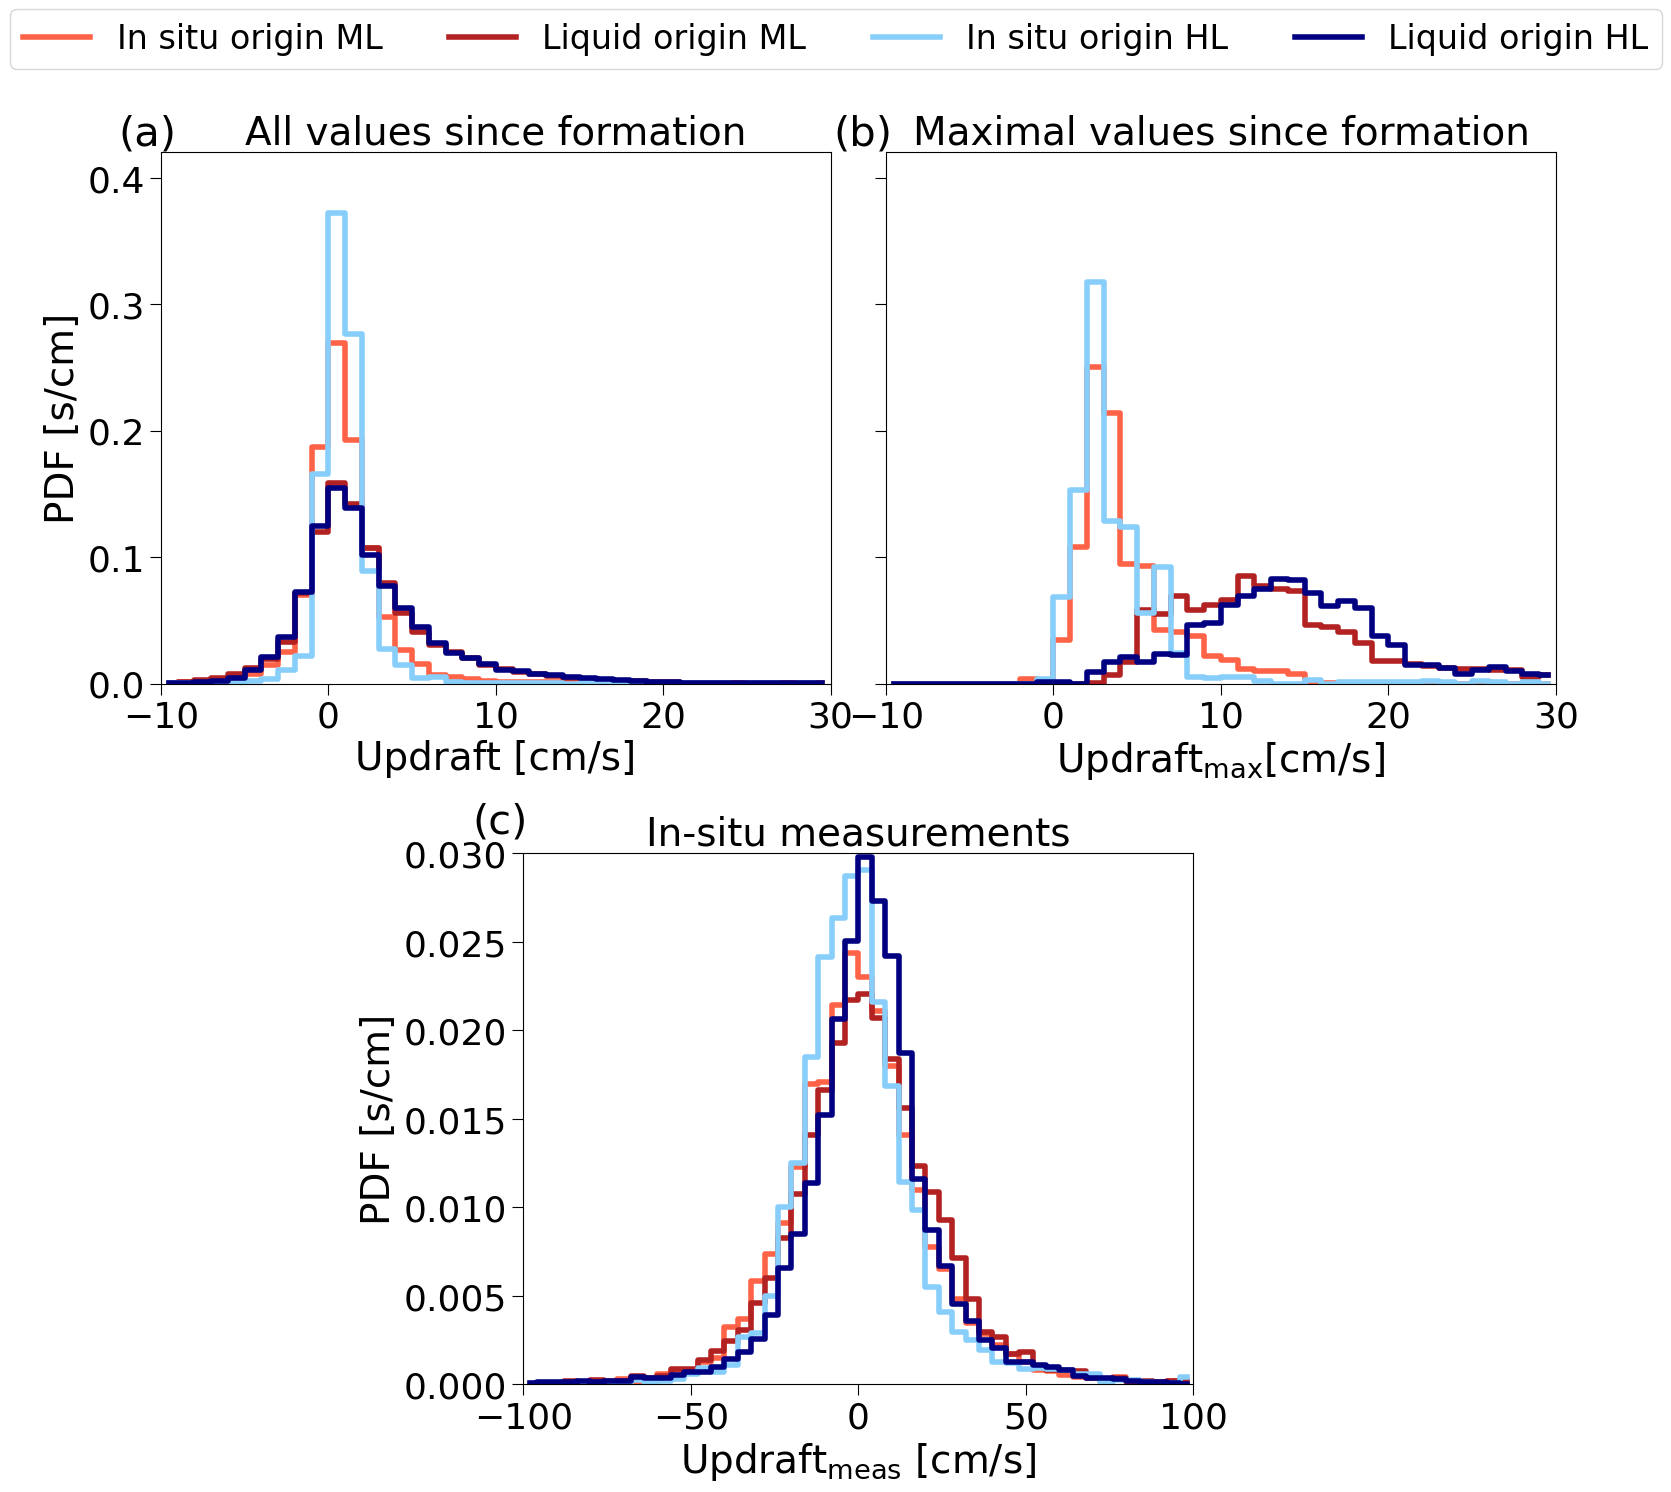

In [25]:
fig = plt.figure(figsize=(18,16))
gs = GridSpec(2,4, hspace=0.32, wspace=0.18)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax1)
ax3 = fig.add_subplot(gs[1, 1:3])

wedges = np.linspace(-10, 30, num=41)
wmids = (wedges[:-1] + wedges[1:])/2

hisML, edges = np.histogram(upw_isML, bins=wedges)
his_maxML, edges = np.histogram(max_w_isML, bins=wedges)
hliqML, edges = np.histogram(upw_liqML, bins=wedges)
hliq_maxML, edges = np.histogram(max_w_liqML, bins=wedges)
hisHL, edges = np.histogram(upw_isHL, bins=wedges)
his_maxHL, edges = np.histogram(max_w_isHL, bins=wedges)
hliqHL, edges = np.histogram(upw_liqHL, bins=wedges)
hliq_maxHL, edges = np.histogram(max_w_liqHL, bins=wedges)

hisML = hisML/hisML.sum()
hliqML = hliqML/hliqML.sum()
hisHL = hisHL/hisHL.sum()
hliqHL = hliqHL/hliqHL.sum()
his_maxML = his_maxML/his_maxML.sum()
hliq_maxML = hliq_maxML/hliq_maxML.sum()
his_maxHL = his_maxHL/his_maxHL.sum()
hliq_maxHL = hliq_maxHL/hliq_maxHL.sum()

ax1.semilogy(wmids, hisML, color='tomato', drawstyle='steps-mid', label='In situ origin ML', linewidth=4)
ax1.semilogy(wmids, hliqML, color='firebrick', drawstyle='steps-mid', label='Liquid origin ML', linewidth=4)
ax2.semilogy(wmids, his_maxML, color='tomato', drawstyle='steps-mid', linewidth=4)
ax2.semilogy(wmids, hliq_maxML, color='firebrick', drawstyle='steps-mid', linewidth=4)

ax1.semilogy(wmids, hisHL, color='lightskyblue', drawstyle='steps-mid', label='In situ origin HL', linewidth=4)
ax1.semilogy(wmids, hliqHL, color='navy', drawstyle='steps-mid', label='Liquid origin HL', linewidth=4)
ax2.semilogy(wmids, his_maxHL, color='lightskyblue', drawstyle='steps-mid', linewidth=4)
ax2.semilogy(wmids, hliq_maxHL, color='navy', drawstyle='steps-mid', linewidth=4)

wedges = np.linspace(-100, 100, num=51)
wmids = (wedges[:-1] + wedges[1:])/2

upwis_isML = campaign[(campaign.type==1)&(campaign.lat_o_is <60)].updraft_is
upwis_liqML = campaign[(campaign.type==0)&(campaign.lat_o_is <60)].updraft_is
upwis_isHL = campaign[(campaign.type==1)&(campaign.lat_o_is >=60)].updraft_is
upwis_liqHL = campaign[(campaign.type==0)&(campaign.lat_o_is >=60)].updraft_is

hisML, edges = np.histogram(upwis_isML, bins=wedges)
hliqML, edges = np.histogram(upwis_liqML, bins=wedges)
hisHL, edges = np.histogram(upwis_isHL, bins=wedges)
hliqHL, edges = np.histogram(upwis_liqHL, bins=wedges)

hisML = hisML/hisML.sum()/(wedges[1]-wedges[0])
hliqML = hliqML/hliqML.sum()/(wedges[1]-wedges[0])
hisHL = hisHL/hisHL.sum()/(wedges[1]-wedges[0])
hliqHL = hliqHL/hliqHL.sum()/(wedges[1]-wedges[0])

ax3.semilogy(wmids, hisML, color='tomato', drawstyle='steps-mid', linewidth=4)
ax3.semilogy(wmids, hliqML, color='firebrick', drawstyle='steps-mid', linewidth=4)

ax3.semilogy(wmids, hisHL, color='lightskyblue', drawstyle='steps-mid', linewidth=4)
ax3.semilogy(wmids, hliqHL, color='navy', drawstyle='steps-mid', linewidth=4)

ax1.set_yscale('linear')
ax2.set_yscale('linear')
ax3.set_yscale('linear')
ax1.set_ylabel('PDF [s/cm]', fontsize=28)
ax1.set_xlabel('Updraft [cm/s]', fontsize=28)
ax3.set_ylabel('PDF [s/cm]', fontsize=28)
ax3.set_xlabel(r'$\mathrm{Updraft_{meas}}$ [cm/s]', fontsize=28)
ax1.set_xlim(-10, 30)
ax2.set_xlim(-10, 30)
ax3.set_xlim(-100, 100)
ax1.set_ylim(0, 0.42)
ax3.set_ylim(0, 0.03)
ax2.set_xlabel(r'$\mathrm{Updraft_{max} [cm/s]}$', fontsize=28)
ax1.tick_params(axis='both', which='major', labelsize=26, length=8)
ax2.tick_params(axis='both', which='major', labelsize=26, length=8)
ax3.tick_params(axis='both', which='major', labelsize=26, length=8)
ax1.set_title('All values since formation', fontsize=28)
ax2.set_title('Maximal values since formation', fontsize=28)
ax3.set_title('In-situ measurements', fontsize=28)

plt.setp(ax2.get_yticklabels(), visible=False)

ax1.annotate('(a)', xy=(85, 970), xycoords='figure points', fontsize=30)
ax2.annotate('(b)', xy=(600, 970), xycoords='figure points', fontsize=30)
ax3.annotate('(c)', xy=(340, 475), xycoords='figure points', fontsize=30)

fig.legend(bbox_to_anchor=(0.5,0.98), loc='upper center', fontsize=24, ncol=4)

In [26]:
liq = campaign.loc[(campaign.N_0_is > 1e-1)&(campaign.ED_0_is<40)&(campaign.type==0)&(campaign.altitude > 8000)]
ins = campaign.loc[(campaign.N_0_is > 1e-1)&(campaign.ED_0_is<40)&(campaign.type==1)&(campaign.altitude > 8000)]
df_auxliq = liq.groupby(['n']).mean()
df_auxins = ins.groupby(['n']).mean()

upw_liq = []
list_alt = []
list_time = []
max_w_liq = []

for i, ind in enumerate(df_auxliq.index):
    pos = int(liq[liq.n == ind].duration[0])+1
    N = liq[liq.n == ind].N_0_is.mean()
    typ = liq[liq.n == ind].type[0]
    marker = ['x' if typ == 1 else 'o']
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    time = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].index
    alt = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].p
    
    max_w_liq.append(max(updraft))
    upw_liq= upw_liq + updraft.values.tolist()
    list_alt= list_alt + alt.values.tolist()
    list_time = list_time + time.values.tolist()
    

upw_is = []
list_alt = []
list_time = []
max_w_is = []

for i, ind in enumerate(df_auxins.index):
    pos = int(ins[ins.n == ind].duration[0])+1
    N = ins[ins.n == ind].N_0_is.mean()
    typ = ins[ins.n == ind].type[0]
    marker = ['x' if typ == 1 else 'o']
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    time = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].index
    alt = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].p
    
    max_w_is.append(max(updraft))
    upw_is= upw_is + updraft.values.tolist()
    list_alt= list_alt + alt.values.tolist()
    list_time = list_time + time.values.tolist()

In [27]:
selis = (campaign.N_0_is > 1e-1)&(campaign.ED_0_is<40)&(campaign.type==1)&(campaign.altitude > 8000)
selliq = (campaign.N_0_is > 1e-1)&(campaign.ED_0_is<40)&(campaign.type==0)&(campaign.altitude > 8000)

In [28]:
newlist_w_liq = []
for i,item in enumerate(df_auxliq.index):
    number = len(campaign[(campaign.n == int(item))&selliq])
    newlist_w_liq = newlist_w_liq + [max_w_liq[i]]*number

In [29]:
newlist_w_is = []
for i,item in enumerate(df_auxins.index):
    number = len(campaign[(campaign.n == int(item))&selis])
    newlist_w_is = newlist_w_is + [max_w_is[i]]*number

In [30]:
list_all = []
list_max = []
df_aux = campaign.groupby(['n']).mean()
for i, ind in enumerate(df_aux.index):
    pos = int(campaign[campaign.n == ind].duration[0])+1
    updraft = data_raw_tray[data_raw_tray.n == ind].iloc[:pos].w_up
    number = len(campaign[campaign.n==ind])
    list_all= list_all + updraft.values.tolist()
    list_max = list_max + [max(updraft)]*number

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  


Text(520, 380, '(d)')

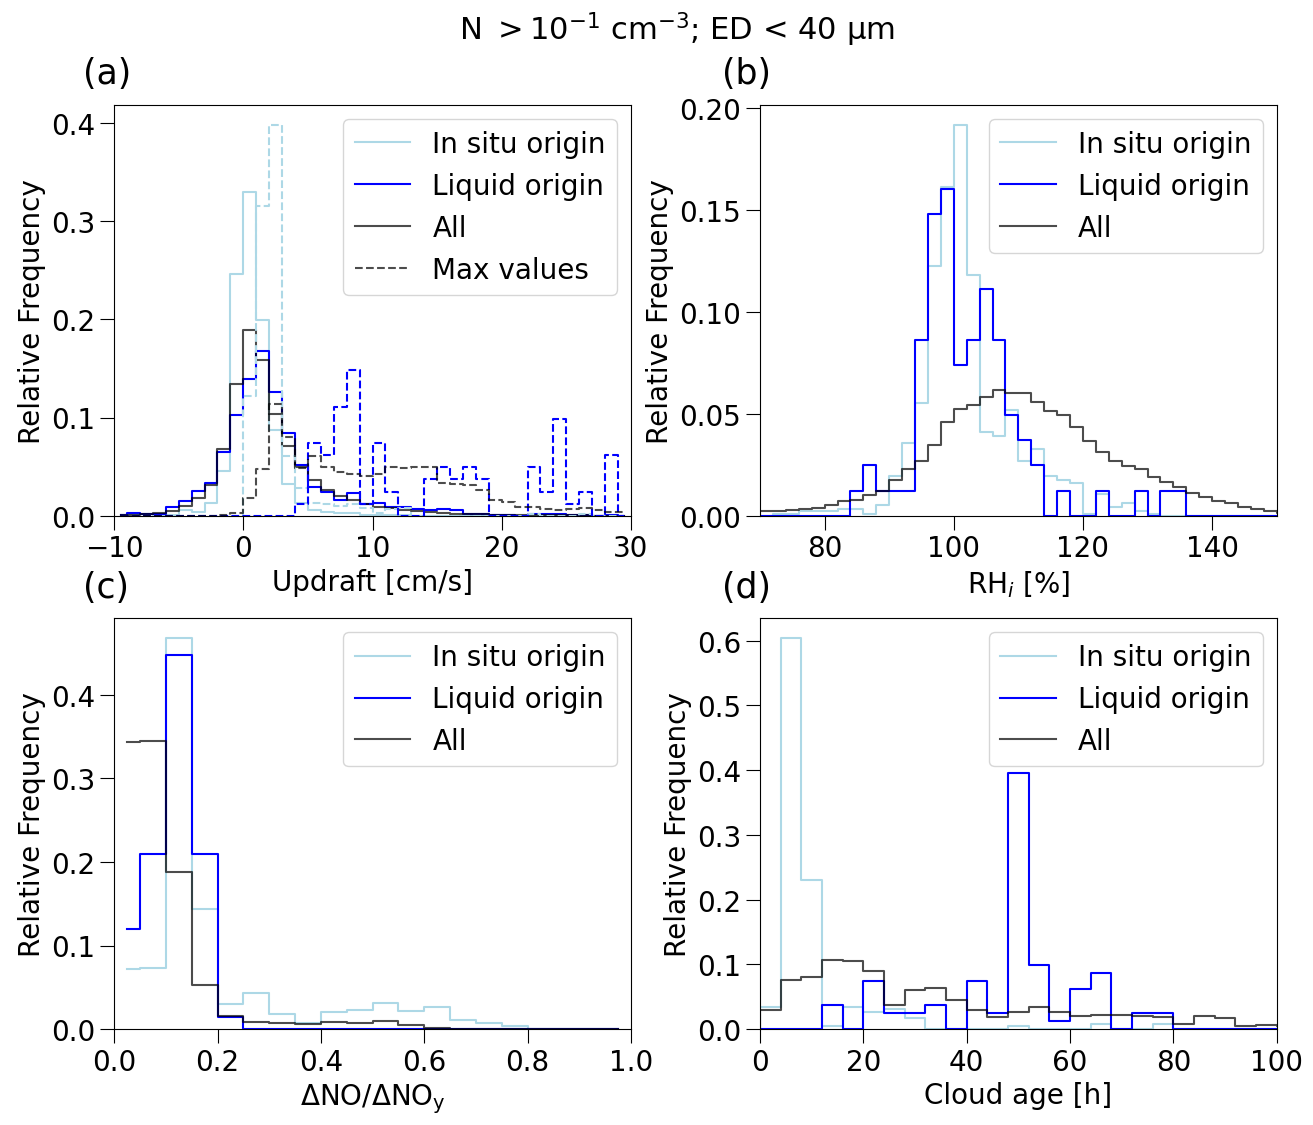

In [31]:
fig = plt.figure(figsize=(15,12))
gs = GridSpec(2,2, wspace=0.25, hspace=0.25)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

#wedges(-10,30)
wedges = np.linspace(-10, 30, num=41)
wmids = (wedges[:-1] + wedges[1:])/2
noyedges = np.logspace(-1, 1, num=31)
noedges = np.linspace(0, 3, num=31)
noyedges = np.linspace(-1, 10, num=45)
no_noyedges = np.linspace(0, 1, num=21)
noymids = 10**((np.log10(noyedges[:-1]) + np.log10(noyedges[1:]))/2)
nomids = (noedges[:-1] + noedges[1:])/2
no_noymids = (no_noyedges[:-1] + no_noyedges[1:])/2
noymids = (noyedges[:-1] + noyedges[1:])/2
rhedges = np.linspace(60, 160, num=51)
rhmids = (rhedges[:-1] + rhedges[1:])/2
dedges = np.linspace(-4, 140, num=37)
dmids = (dedges[:-1] + dedges[1:])/2

selis = (campaign.N_0_is > 1e-1)&(campaign.ED_0_is<40)&(campaign.type==1)&(campaign.altitude>8000)
selliq = (campaign.N_0_is > 1e-1)&(campaign.ED_0_is<40)&(campaign.type==0)&(campaign.altitude>8000)

h1is, edges = np.histogram(upw_is, bins=wedges)
h1is_max, edges = np.histogram(newlist_w_is, bins=wedges)
h1liq, edges = np.histogram(upw_liq, bins=wedges)
h1liq_max, edges = np.histogram(newlist_w_liq, bins=wedges)
h1all, edges = np.histogram(list_all, bins=wedges)
h1all_max, edges = np.histogram(list_max, bins=wedges)

h1is = h1is/h1is.sum()
h1liq = h1liq/h1liq.sum()
h1all = h1all/h1all.sum()
h1is_max = h1is_max/h1is_max.sum()
h1liq_max = h1liq_max/h1liq_max.sum()
h1all_max = h1all_max/h1all_max.sum()

ax1.semilogy(wmids, h1is, color='lightblue', drawstyle='steps-mid', label='In situ origin')
ax1.semilogy(wmids, h1liq, color='blue', drawstyle='steps-mid', label='Liquid origin')
ax1.semilogy(wmids, h1all, color='black',drawstyle='steps-mid', label='All', alpha=0.7)
ax1.semilogy(wmids, h1is_max, color='lightblue', drawstyle='steps-mid', linestyle='dashed')
ax1.semilogy(wmids, h1liq_max, color='blue', drawstyle='steps-mid', linestyle='dashed')
ax1.semilogy(wmids, h1all_max, color='black',drawstyle='steps-mid', linestyle='dashed', alpha=.7)

h1is, edges = np.histogram(campaign.loc[selis].NO/campaign.loc[selis].NOy, bins=no_noyedges)
h1liq, edges = np.histogram(campaign.loc[selliq].NO/campaign.loc[selliq].NOy, bins=no_noyedges)
h1all, edges = np.histogram(campaign.NO/campaign.NOy, bins=no_noyedges)

h1is = h1is/h1is.sum()
h1liq = h1liq/h1liq.sum()
h1all = h1all/h1all.sum()

ax2.semilogy(no_noymids, h1is, color='lightblue', drawstyle='steps-mid', label='In situ origin')
ax2.semilogy(no_noymids, h1liq, color='blue', drawstyle='steps-mid', label='Liquid origin')
ax2.semilogy(no_noymids, h1all, color='black',drawstyle='steps-mid', label='All', alpha=0.7)

h1is, edges = np.histogram(campaign.loc[selis].RH_ice, bins=rhedges)
h1liq, edges = np.histogram(campaign.loc[selliq].RH_ice, bins=rhedges)
h1all, edges = np.histogram(campaign.RH_ice, bins=rhedges)

h1is = h1is/h1is.sum()
h1liq = h1liq/h1liq.sum()
h1all = h1all/h1all.sum()

ax3.semilogy(rhmids, h1is, color='lightblue', drawstyle='steps-mid', label='In situ origin')
ax3.semilogy(rhmids, h1liq, color='blue', drawstyle='steps-mid', label='Liquid origin')
ax3.semilogy(rhmids, h1all, color='black',drawstyle='steps-mid', label='All', alpha=0.7)

h1is, edges = np.histogram(campaign.loc[selis].duration, bins=dedges)
h1liq, edges = np.histogram(campaign.loc[selliq].duration, bins=dedges)
h1all, edges = np.histogram(campaign.duration, bins=dedges)

h1is = h1is/h1is.sum()
h1liq = h1liq/h1liq.sum()
h1all = h1all/h1all.sum()

ax4.semilogy(dmids, h1is, color='lightblue', drawstyle='steps-mid', label='In situ origin')
ax4.semilogy(dmids, h1liq, color='blue', drawstyle='steps-mid', label='Liquid origin')
ax4.semilogy(dmids, h1all, color='black',drawstyle='steps-mid', label='All', alpha=0.7)

#ax2.set_xscale('log')
ax1.set_yscale('linear')
ax2.set_yscale('linear')
ax3.set_yscale('linear')
ax4.set_yscale('linear')
ax1.set_xlabel('Updraft [cm/s]', fontsize=20)
ax2.set_xlabel(r'$\mathrm{\Delta NO/ \Delta NO_y} $', fontsize=20)
ax3.set_xlabel('RH$_{i}$ [%]', fontsize=20)
ax4.set_xlabel('Cloud age [h]', fontsize=20)
ax1.set_ylabel('Relative Frequency', fontsize=20)
ax2.set_ylabel('Relative Frequency', fontsize=20)
ax3.set_ylabel('Relative Frequency', fontsize=20)
ax4.set_ylabel('Relative Frequency', fontsize=20)

ax1.set_xlim(-10, 30)
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
ax2.set_xlim(0, 1)
ax3.set_xlim(70, 150)
ax4.set_xlim(0, 100)
h = ax1.get_lines()
ax1.legend(handles=h[:3]+[h[5]], labels=['In situ origin', 'Liquid origin', 'All', 'Max values'], fontsize=20)
ax2.legend(fontsize=20)
ax3.legend(fontsize=20)
ax4.legend(fontsize=20)

fig.suptitle(r'N $> 10^{-1}$ cm$^{-3}$; ED < 40 µm', fontsize=22, y=0.96)

ax1.tick_params(axis='both', which='major', length=10, labelsize=20)
ax1.tick_params(axis='both', which='minor', length=5)
ax2.tick_params(axis='both', which='major', length=10, labelsize=20)
ax2.tick_params(axis='both', which='minor', length=5)
ax3.tick_params(axis='both', which='major', length=10, labelsize=20)
ax3.tick_params(axis='both', which='minor', length=5)
ax4.tick_params(axis='both', which='major', length=10, labelsize=20)
ax4.tick_params(axis='both', which='minor', length=5)

ax1.annotate('(a)', xy=(60, 750), xycoords='figure points', fontsize=25)
ax2.annotate('(b)', xy=(520, 750), xycoords='figure points', fontsize=25)
ax3.annotate('(c)', xy=(60, 380), xycoords='figure points', fontsize=25)
ax4.annotate('(d)', xy=(520, 380), xycoords='figure points', fontsize=25)

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Text(-0.01, 1.03, '(b)')

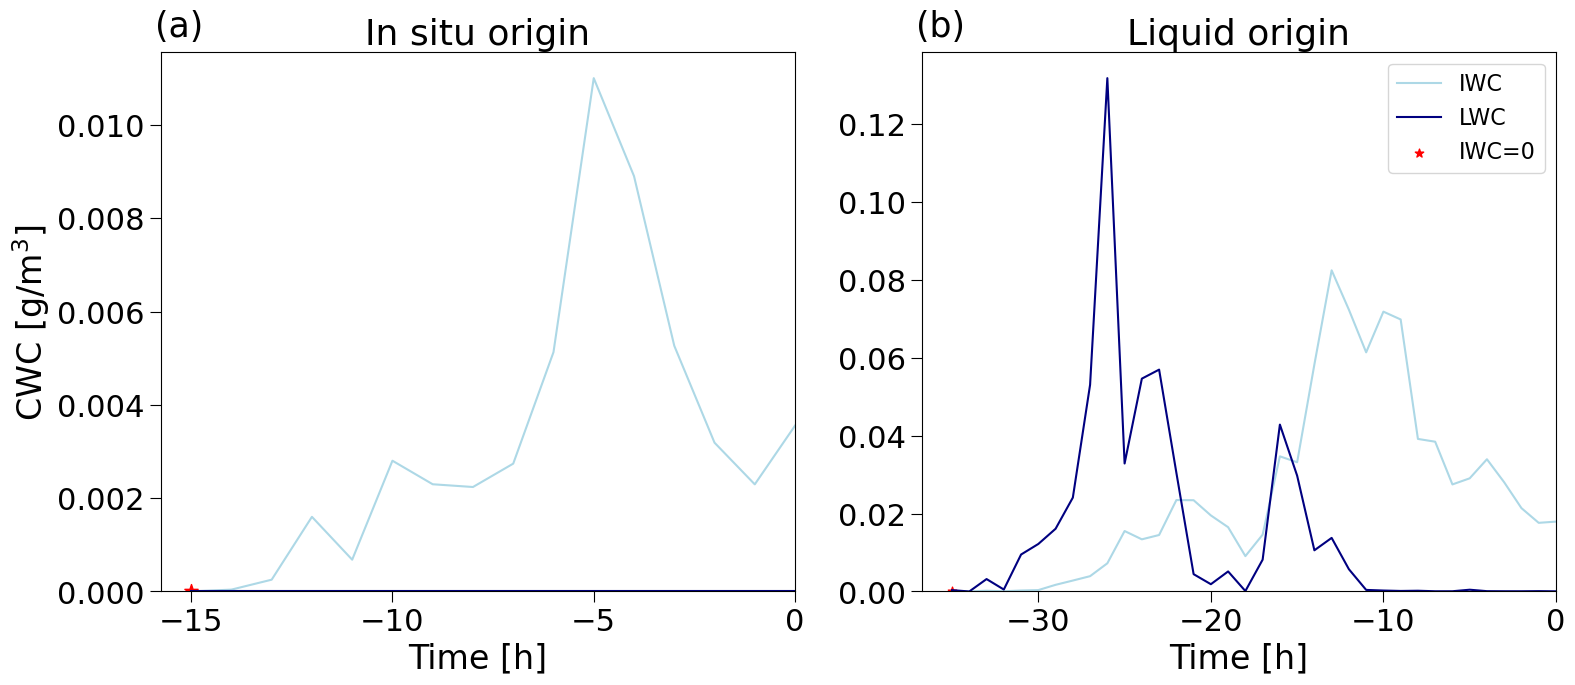

In [8]:
def iwc_to_ISunits(iwc, p, T):
    iwc_is = iwc*p/(287.05*(T+273.15))*1e-4
    return iwc_is

fig = plt.figure(figsize=(18, 7))
gs = GridSpec(1,2, wspace=0.2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

part = campaign[(campaign.type == 1)]

item = part.n[470]
ind = int(part.duration[470] + 2)
line = data_raw_tray[data_raw_tray.n == item]
line['IWC'] = iwc_to_ISunits(line.IWC, line.p, line['T'])*1e3
line['LWC'] = iwc_to_ISunits(line.LWC, line.p, line['T'])*1e3
line[line==0] = 1e-7
    
ax1.plot(line.iloc[:ind].IWC, 'lightblue', label='IWC')
ax1.plot(line.iloc[:ind].LWC, 'navy', label='LWC')
ax1.scatter(line.iloc[ind-1:ind].index, line.iloc[ind-1:ind].IWC, c='red', marker='*', s=100, label='IWC=0')

part = campaign[(campaign.type == 0)&(campaign.lat_o_is <71)]

item = part.n[5500]
ind = int(part.duration[5500] + 2)
line = data_raw_tray[data_raw_tray.n == item]
line['IWC'] = iwc_to_ISunits(line.IWC, line.p, line['T'])*1e3
line['LWC'] = iwc_to_ISunits(line.LWC, line.p, line['T'])*1e3
line[line==0] = 1e-7
    
ax2.plot(line.iloc[:ind].IWC, 'lightblue', label='IWC')
ax2.plot(line.iloc[:ind].LWC, 'navy', label='LWC')
ax2.scatter(line.iloc[ind-1:ind].index, line.iloc[ind-1:ind].IWC, c='red', marker='*', s=40, label='IWC=0')


ax1.tick_params(axis='both', which='major', length=8, labelsize=22)
ax2.tick_params(axis='both', which='major', length=8, labelsize=22)

#plt.yscale('log')
ax1.set_ylim(bottom=0)
ax1.set_xlim(right=0)
ax2.set_ylim(bottom=0)
ax2.set_xlim(right=0)
ax1.set_xlabel('Time [h]', fontsize=24)
ax1.set_title('In situ origin', fontsize=26)
ax2.set_title('Liquid origin', fontsize=26)
ax2.set_xlabel('Time [h]', fontsize=24)
ax1.set_ylabel('CWC [$\mathrm{g/m^3}$]', fontsize=24)
plt.legend(fontsize=16)

ax1.annotate('(a)', xy=(-0.01, 1.03), xycoords='axes fraction', fontsize=25)
ax2.annotate('(b)', xy=(-0.01, 1.03), xycoords='axes fraction', fontsize=25)

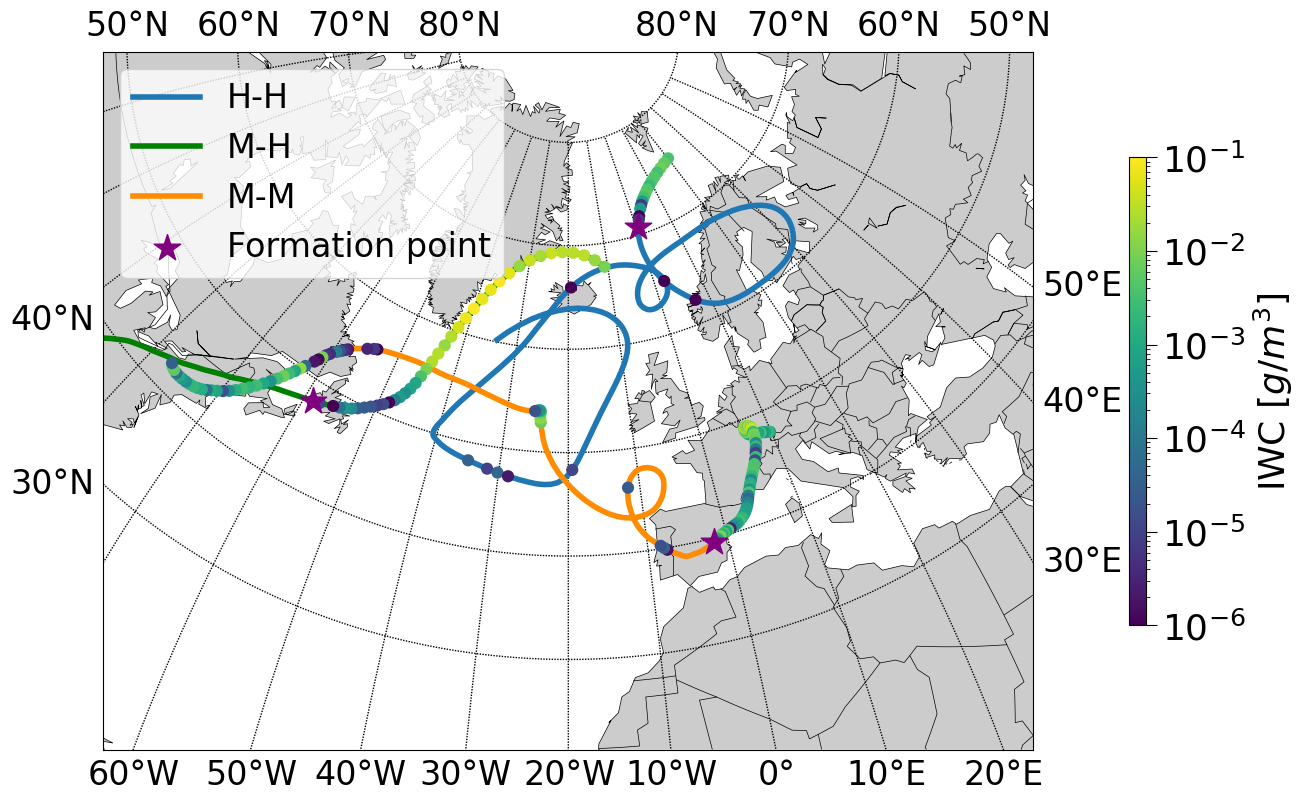

In [32]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
# Map Definition

fig = plt.figure(figsize=(12,12))

#m = Basemap(projection='cyl', llcrnrlat=35, urcrnrlat=80,llcrnrlon=-20, urcrnrlon=40, resolution='c', area_thresh=1000.)
#m = Basemap(projection='lcc', width=5E6, height=5E6, lat_0=60, lon_0=0, lat_1=60, lat_2=70)
m = Basemap(projection='aeqd',lon_0 = -20,lat_0 = 55,width = 10000000,height = 7500000)

#m.bluemarble(scale=0.5)
#m.etopo(scale=0.5, alpha=0.75)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.fillcontinents()

#Draw parallels and meridians
m.drawparallels(np.arange(30., 85.,10.), labels=[1, 0, 1, 0], fontsize=24)
m.drawmeridians(np.arange(-120.,60.,10.), labels=[0, 1, 0, 1], fontsize=24)
zo=2
lat = []
lon = []

p1 = campaign[(campaign.lat_o_is >= 65)&(campaign.lat_f <50)].iloc[0]
n1 = p1.n
form1 = int(p1.duration)
iwc = iwc_to_ISunits(data_raw_tray[data_raw_tray.n==n1].IWC, data_raw_tray[data_raw_tray.n==n1].p,
                     data_raw_tray[data_raw_tray.n==n1]['T'])*1e3

p2 = campaign[(campaign.lat_o_is >= 65)&(campaign.lat_f >70)].iloc[50]
n2 = p2.n
form2= int(p2.duration)
iwc2 = iwc_to_ISunits(data_raw_tray[data_raw_tray.n==n2].IWC, data_raw_tray[data_raw_tray.n==n2].p,
                     data_raw_tray[data_raw_tray.n==n2]['T'])*1e3

p3 = campaign[(campaign.lat_o_is < 50)&(campaign.lat_f <50)].iloc[0]
n3 = p3.n
form3 = int(p3.duration)
iwc3 = iwc_to_ISunits(data_raw_tray[data_raw_tray.n==n3].IWC, data_raw_tray[data_raw_tray.n==n3].p,
                     data_raw_tray[data_raw_tray.n==n3]['T'])*1e3

norm = colors.LogNorm(vmin=1e-6, vmax=1e-1)
orig_map=plt.cm.get_cmap('viridis')
m.plot(data_raw_tray[data_raw_tray.n==n2].lon.values, data_raw_tray[data_raw_tray.n==n2].lat.values, 
       latlon=True, zorder=2, label='H-H', linewidth=4, color='C0')
sc = m.scatter(data_raw_tray[data_raw_tray.n==n2].lon.values, data_raw_tray[data_raw_tray.n==n2].lat.values, latlon=True,
           c=iwc2, norm=norm, cmap=orig_map, zorder=3, s=60)
m.scatter(data_raw_tray[data_raw_tray.n==n2].lon.iloc[form2], data_raw_tray[data_raw_tray.n==n2].lat.iloc[form2], latlon=True,
           c='purple', norm=norm, cmap=orig_map, zorder=3, s=400, marker='*', label='Formation point')

m.plot(data_raw_tray[data_raw_tray.n==n1].lon.values, data_raw_tray[data_raw_tray.n==n1].lat.values, 
       latlon=True, zorder=2, label='M-H', linewidth=4, color='green')
sc = m.scatter(data_raw_tray[data_raw_tray.n==n1].lon.values, data_raw_tray[data_raw_tray.n==n1].lat.values, latlon=True,
           c=iwc, norm=norm, cmap=orig_map, zorder=3, s=60)
m.scatter(data_raw_tray[data_raw_tray.n==n1].lon.iloc[form1], data_raw_tray[data_raw_tray.n==n1].lat.iloc[form1], latlon=True,
           c='purple', norm=norm, cmap=orig_map, zorder=3, s=400, marker='*')

m.plot(data_raw_tray[data_raw_tray.n==n3].lon.values, data_raw_tray[data_raw_tray.n==n3].lat.values, 
       latlon=True, zorder=2, label='M-M', linewidth=4, color='darkorange')
sc = m.scatter(data_raw_tray[data_raw_tray.n==n3].lon.values, data_raw_tray[data_raw_tray.n==n3].lat.values, latlon=True,
           c=iwc3, norm=norm, cmap=orig_map, zorder=3, s=60)
m.scatter(data_raw_tray[data_raw_tray.n==n3].lon.iloc[form3], data_raw_tray[data_raw_tray.n==n3].lat.iloc[form3], latlon=True,
           c='purple', norm=norm, cmap=orig_map, zorder=3, s=400, marker='*')

plt.legend(loc='upper left', fontsize=24)

cbar_ax = fig.add_axes([0.98, 0.308, 0.014, 0.39])
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label('IWC [$g/m^3$]', fontsize=26)
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.tick_params(axis='y', which='major', length=8, labelsize=26)
cbar_ax.tick_params(axis='y', which='minor', length=3)
plt.show()

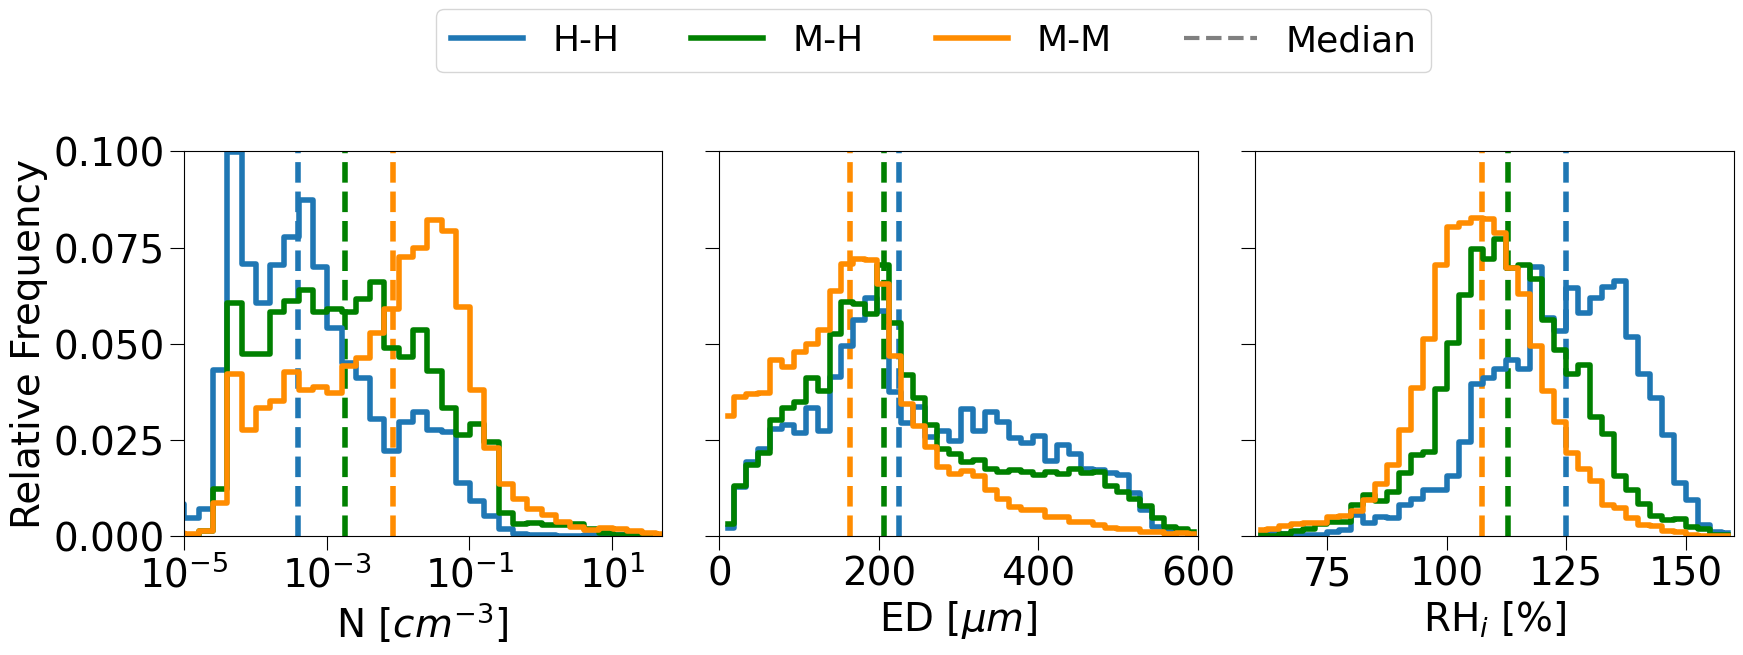

In [33]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(20,5))
gs = GridSpec(1,3, hspace=0.25, wspace=0.12)

custom = Line2D([], [], color='gray', lw=3, linestyle='dashed', label='Median')

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

nedges = np.logspace(-6, 2, num=41)
nmids = 10**((np.log10(nedges[:-1]) + np.log10(nedges[1:]))/2)
ededges = np.linspace(3, 603, num=41)
edmids = (ededges[:-1] + ededges[1:])/2
riedges = np.linspace(60, 160, num=41)
rimids = (riedges[:-1]+ riedges[1:])/2

thres = 60

selnn = (campaign.lat_o_is >= thres)&(campaign.lat_f >= thres)
selsn = (campaign.lat_o_is >= thres)&(campaign.lat_f < thres)
selss = (campaign.lat_o_is < thres)&(campaign.lat_f < thres)
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
nsel = ((campaign.N_0_is >= 1e-6)&(campaign.N_0_is <= 1e2))
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
rhisel = ((campaign.RH_ice >= 60)&(campaign.RH_ice <= 160))


h1nn, nedges = np.histogram(campaign[selnn].N_0_is, bins=nedges)
h1sn, nedges = np.histogram(campaign[selsn].N_0_is, bins=nedges)
h1ss, nedges = np.histogram(campaign[selss].N_0_is, bins=nedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax1.semilogy(nmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax1.semilogy(nmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax1.semilogy(nmids,h1ss, color='darkorange',drawstyle='steps-mid', label='M-M', linewidth=4)
ax1.vlines(campaign[nsel&selnn].N_0_is.median(), 0, 0.1, linestyle='dashed', color='C0', linewidth=4)
ax1.vlines(campaign[nsel&selsn].N_0_is.median(), 0, 0.1, linestyle='dashed', color='green', linewidth=4)
ax1.vlines(campaign[nsel&selss].N_0_is.median(), 0, 0.1, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, ededges = np.histogram(campaign[selnn].ED_0_is, bins=ededges)
h1sn, ededges = np.histogram(campaign[selsn].ED_0_is, bins=ededges)
h1ss, ededges = np.histogram(campaign[selss].ED_0_is, bins=ededges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax2.semilogy(edmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax2.semilogy(edmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax2.semilogy(edmids, h1ss, color='darkorange', drawstyle='steps-mid', label='M-M', linewidth=4)
ax2.vlines(campaign[edsel&selnn].ED_0_is.median(), 0, 0.1, linestyle='dashed', color='C0', label='Medians', linewidth=4)
ax2.vlines(campaign[edsel&selsn].ED_0_is.median(), 0, 0.1, linestyle='dashed', color='green', linewidth=4)
ax2.vlines(campaign[edsel&selss].ED_0_is.median(), 0, 0.1, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, riedges = np.histogram(campaign[selnn].RH_ice, bins=riedges)
h1sn, riedges = np.histogram(campaign[selsn].RH_ice, bins=riedges)
h1ss, riedges = np.histogram(campaign[selss].RH_ice, bins=riedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax3.semilogy(rimids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax3.semilogy(rimids, h1sn, color='green', drawstyle='steps-mid', label='formed ML, meas. HL', linewidth=4)
ax3.semilogy(rimids, h1ss, color='darkorange', drawstyle='steps-mid', label='formed, meas. ML', linewidth=4)
ax3.vlines(campaign[rhisel&selnn].RH_ice.median(), 0, 0.1, linestyle='dashed', color='C0', linewidth=4)
ax3.vlines(campaign[rhisel&selsn].RH_ice.median(), 0, 0.1, linestyle='dashed', color='green', linewidth=4)
ax3.vlines(campaign[rhisel&selss].RH_ice.median(), 0, 0.1, linestyle='dashed', color='darkorange', linewidth=4)

ax1.set_xscale('log')
ax1.set_yscale('linear')
ax2.set_yscale('linear')
ax3.set_yscale('linear')
ax1.set_xlabel('N [$cm^{-3}$]', fontsize=28)
ax2.set_xlabel('ED [$\mu m$]', fontsize=28)
ax3.set_xlabel('RH$_{i}$ [%]', fontsize=28)
ax1.set_ylabel('Relative Frequency', fontsize=28)
#ax2.set_ylabel('PDF', fontsize=20)
#ax3.set_ylabel('PDF', fontsize=20)

ax1.set_xlim(1e-5, 5e1)
ax1.set_ylim(0, 0.1)
ax2.set_ylim(0, 0.1)
ax2.set_xlim(0, 600)
ax3.set_xlim(60, 160)
#ax1.legend(fontsize=20)
#ax2.legend(fontsize=20)
#ax3.legend(fontsize=20)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.tick_params(axis='both', which='major', length=10, labelsize=28)
ax1.tick_params(axis='both', which='minor', length=5)
ax2.tick_params(axis='both', which='major', length=10, labelsize=28)
ax2.tick_params(axis='both', which='minor', length=5)
ax3.tick_params(axis='both', which='major', length=10, labelsize=28)
ax3.tick_params(axis='both', which='minor', length=5)

handles, labels = ax1.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

#ax1.annotate('(a)', xy=(90, 375), xycoords='figure points', fontsize=28)
#ax2.annotate('(b)', xy=(475, 375), xycoords='figure points', fontsize=28)
#ax3.annotate('(c)', xy=(860, 375), xycoords='figure points', fontsize=28)

fig.legend(handles, labels, bbox_to_anchor=(0.5,1.2), loc='upper center', fontsize=26, ncol=4)

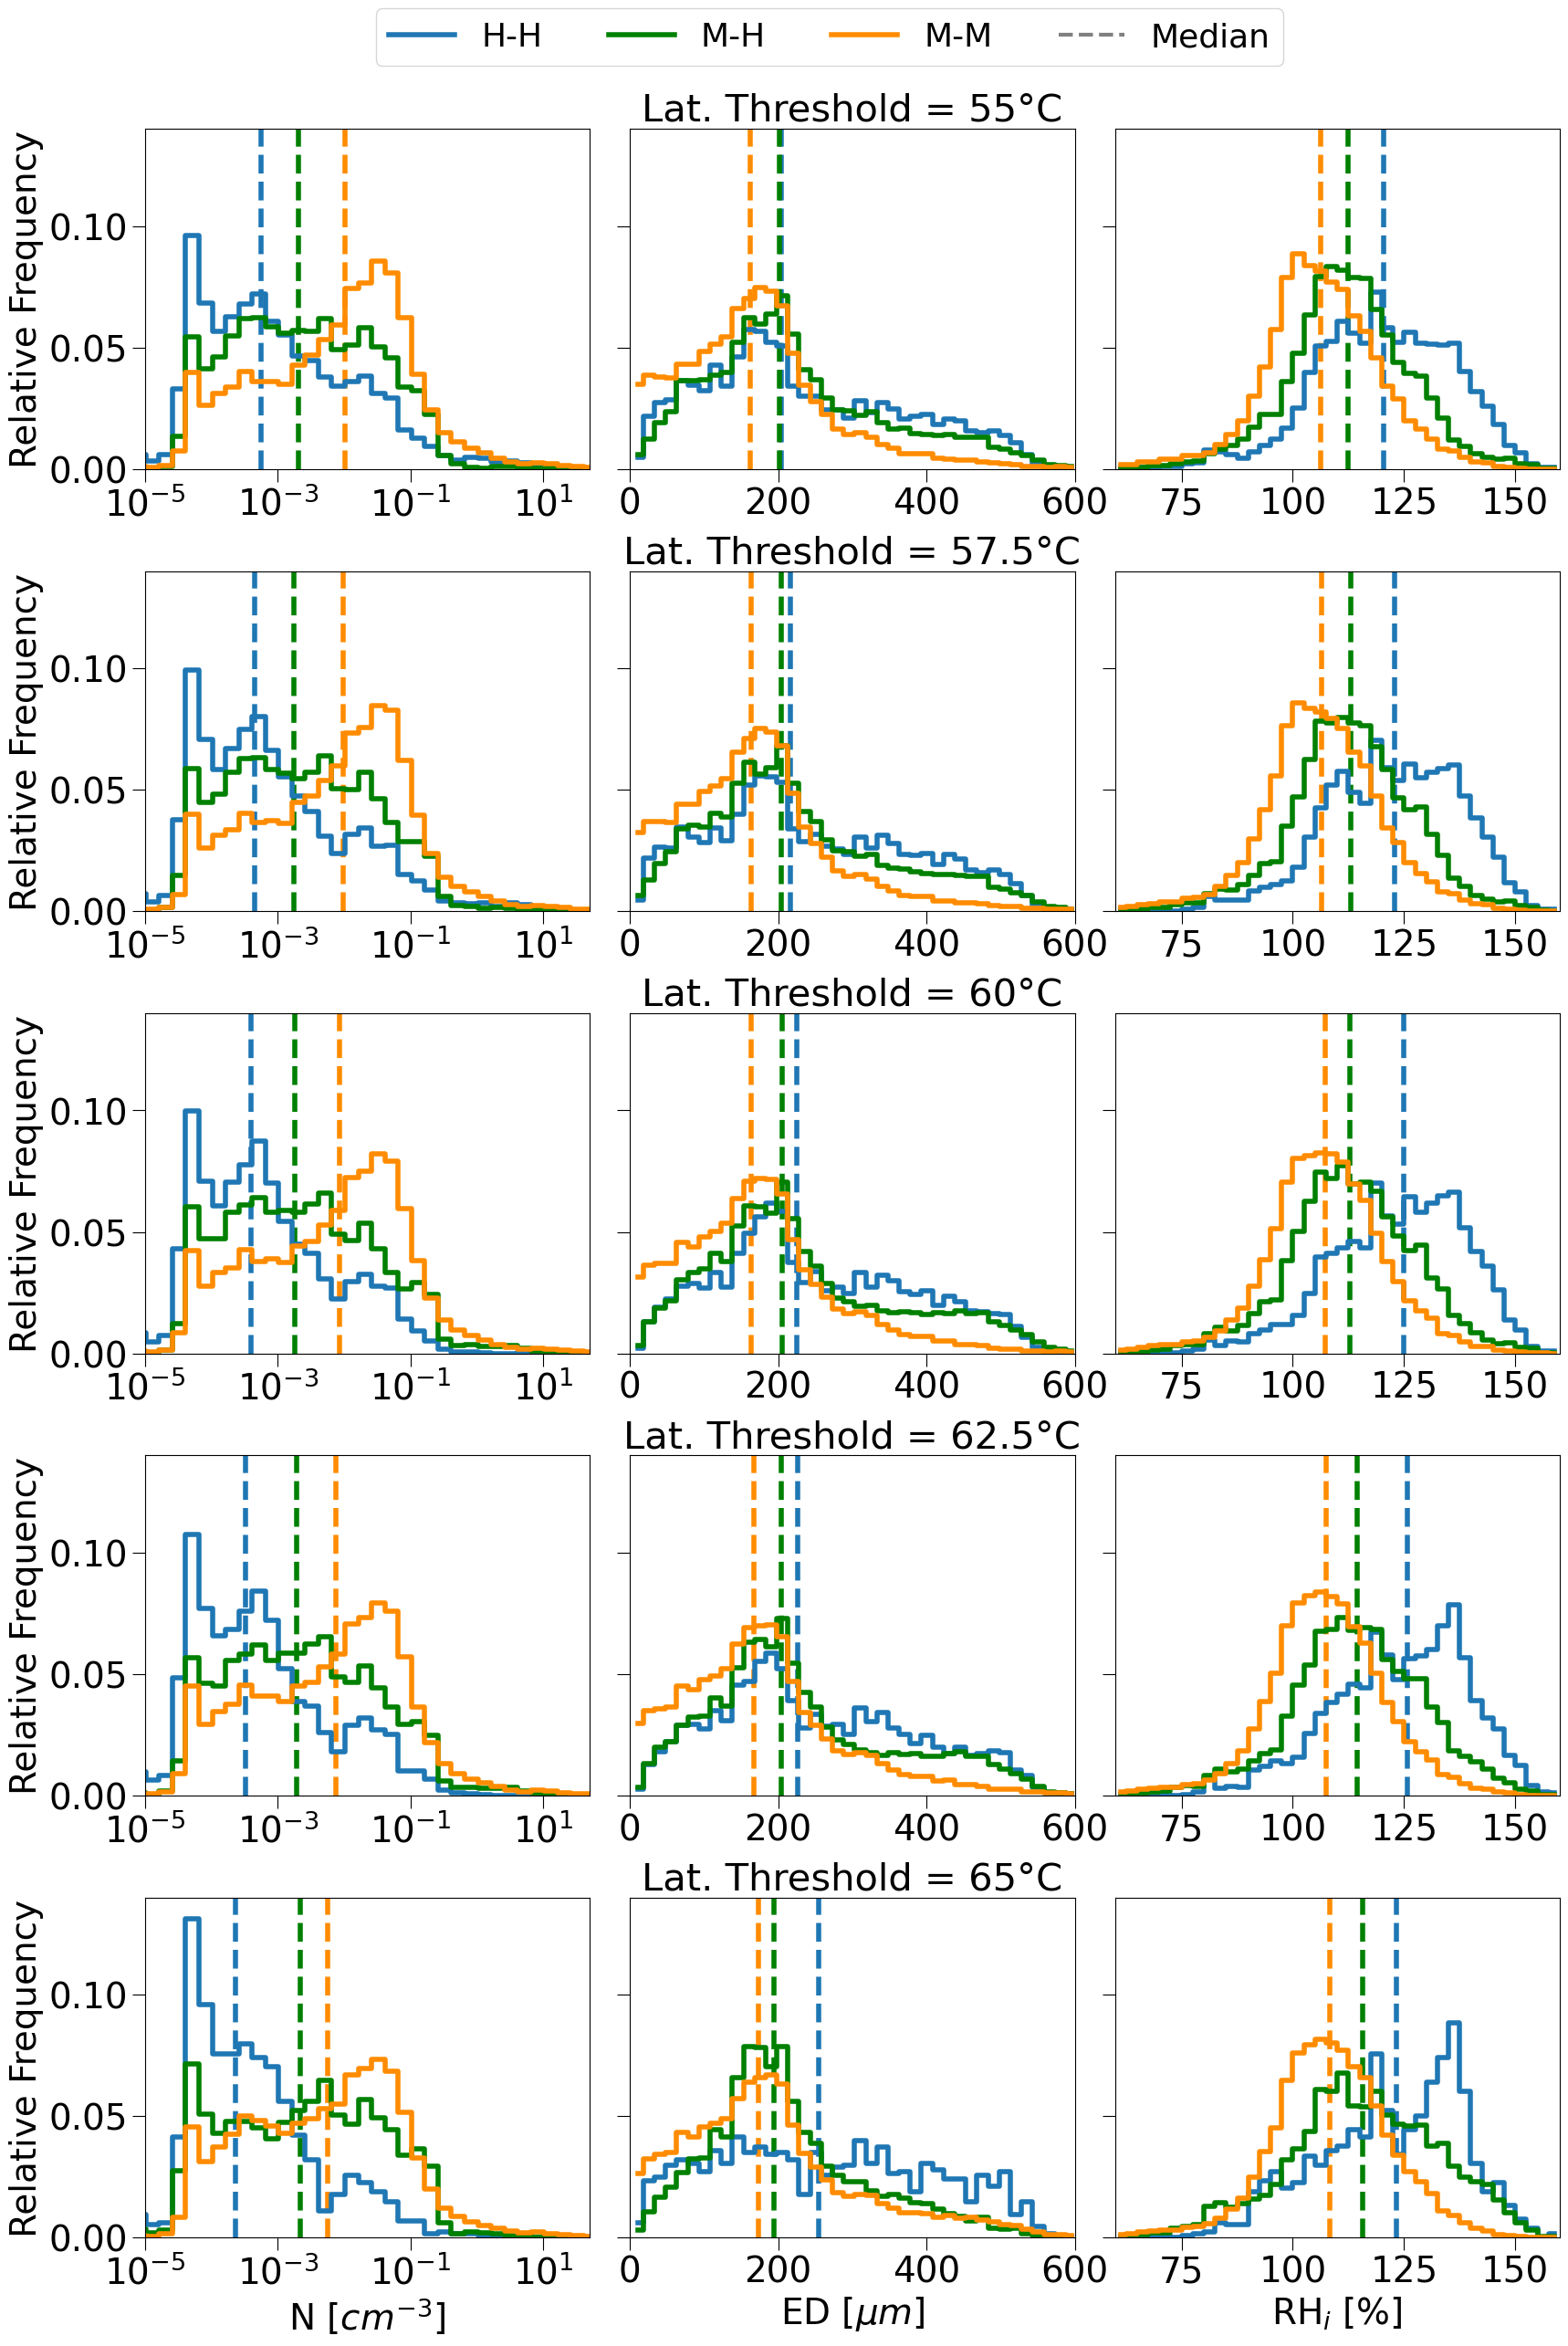

In [34]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(20,30))
gs = GridSpec(5,3, hspace=0.3, wspace=0.09)

custom = Line2D([], [], color='gray', lw=3, linestyle='dashed', label='Median')

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax11 = fig.add_subplot(gs[1, 0], sharey=ax1, sharex=ax1)
ax12 = fig.add_subplot(gs[1, 1], sharey=ax1, sharex=ax2)
ax13 = fig.add_subplot(gs[1, 2], sharey=ax1, sharex=ax3)
ax21 = fig.add_subplot(gs[2, 0], sharey=ax1, sharex=ax1)
ax22 = fig.add_subplot(gs[2, 1], sharey=ax1, sharex=ax2)
ax23 = fig.add_subplot(gs[2, 2], sharey=ax1, sharex=ax3)
ax31 = fig.add_subplot(gs[3, 0], sharey=ax1, sharex=ax1)
ax32 = fig.add_subplot(gs[3, 1], sharey=ax1, sharex=ax2)
ax33 = fig.add_subplot(gs[3, 2], sharey=ax1, sharex=ax3)
ax41 = fig.add_subplot(gs[4, 0], sharey=ax1, sharex=ax1)
ax42 = fig.add_subplot(gs[4, 1], sharey=ax1, sharex=ax2)
ax43 = fig.add_subplot(gs[4, 2], sharey=ax1, sharex=ax3)

nedges = np.logspace(-6, 2, num=41)
nmids = 10**((np.log10(nedges[:-1]) + np.log10(nedges[1:]))/2)
ededges = np.linspace(3, 603, num=41)
edmids = (ededges[:-1] + ededges[1:])/2
riedges = np.linspace(60, 160, num=41)
rimids = (riedges[:-1]+ riedges[1:])/2

thres = 55

selnn = (campaign.lat_o_is >= thres)&(campaign.lat_f >= thres)
selsn = (campaign.lat_o_is >= thres)&(campaign.lat_f < thres)
selss = (campaign.lat_o_is < thres)&(campaign.lat_f < thres)
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
nsel = ((campaign.N_0_is >= 1e-6)&(campaign.N_0_is <= 1e2))
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
rhisel = ((campaign.RH_ice >= 60)&(campaign.RH_ice <= 160))


h1nn, nedges = np.histogram(campaign[selnn].N_0_is, bins=nedges)
h1sn, nedges = np.histogram(campaign[selsn].N_0_is, bins=nedges)
h1ss, nedges = np.histogram(campaign[selss].N_0_is, bins=nedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax1.semilogy(nmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax1.semilogy(nmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax1.semilogy(nmids,h1ss, color='darkorange',drawstyle='steps-mid', label='M-M', linewidth=4)
ax1.vlines(campaign[nsel&selnn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax1.vlines(campaign[nsel&selsn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax1.vlines(campaign[nsel&selss].N_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, ededges = np.histogram(campaign[selnn].ED_0_is, bins=ededges)
h1sn, ededges = np.histogram(campaign[selsn].ED_0_is, bins=ededges)
h1ss, ededges = np.histogram(campaign[selss].ED_0_is, bins=ededges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax2.semilogy(edmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax2.semilogy(edmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax2.semilogy(edmids, h1ss, color='darkorange', drawstyle='steps-mid', label='M-M', linewidth=4)
ax2.vlines(campaign[edsel&selnn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', label='Medians', linewidth=4)
ax2.vlines(campaign[edsel&selsn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax2.vlines(campaign[edsel&selss].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, riedges = np.histogram(campaign[selnn].RH_ice, bins=riedges)
h1sn, riedges = np.histogram(campaign[selsn].RH_ice, bins=riedges)
h1ss, riedges = np.histogram(campaign[selss].RH_ice, bins=riedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax3.semilogy(rimids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax3.semilogy(rimids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax3.semilogy(rimids, h1ss, color='darkorange', drawstyle='steps-mid', label='H-H', linewidth=4)
ax3.vlines(campaign[rhisel&selnn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax3.vlines(campaign[rhisel&selsn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax3.vlines(campaign[rhisel&selss].RH_ice.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

ax1.set_xscale('log')
ax1.set_yscale('linear')
ax2.set_yscale('linear')
ax3.set_yscale('linear')
ax1.set_ylabel('Relative Frequency', fontsize=28)

ax1.set_xlim(1e-5, 5e1)
ax1.set_ylim(0, 0.1)
ax2.set_ylim(0, 0.1)
ax2.set_xlim(0, 600)
ax3.set_xlim(60, 160)

plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

ax1.tick_params(axis='both', which='major', length=10, labelsize=28)
ax1.tick_params(axis='both', which='minor', length=5)
ax2.tick_params(axis='both', which='major', length=10, labelsize=28)
ax2.tick_params(axis='both', which='minor', length=5)
ax3.tick_params(axis='both', which='major', length=10, labelsize=28)
ax3.tick_params(axis='both', which='minor', length=5)

ax2.set_title('Lat. Threshold = '+str(thres) + '°C', fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

thres = 57.5

selnn = (campaign.lat_o_is >= thres)&(campaign.lat_f >= thres)
selsn = (campaign.lat_o_is >= thres)&(campaign.lat_f < thres)
selss = (campaign.lat_o_is < thres)&(campaign.lat_f < thres)
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
nsel = ((campaign.N_0_is >= 1e-6)&(campaign.N_0_is <= 1e2))
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
rhisel = ((campaign.RH_ice >= 60)&(campaign.RH_ice <= 160))


h1nn, nedges = np.histogram(campaign[selnn].N_0_is, bins=nedges)
h1sn, nedges = np.histogram(campaign[selsn].N_0_is, bins=nedges)
h1ss, nedges = np.histogram(campaign[selss].N_0_is, bins=nedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax11.semilogy(nmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax11.semilogy(nmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax11.semilogy(nmids,h1ss, color='darkorange',drawstyle='steps-mid', label='M-M', linewidth=4)
ax11.vlines(campaign[nsel&selnn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax11.vlines(campaign[nsel&selsn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax11.vlines(campaign[nsel&selss].N_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, ededges = np.histogram(campaign[selnn].ED_0_is, bins=ededges)
h1sn, ededges = np.histogram(campaign[selsn].ED_0_is, bins=ededges)
h1ss, ededges = np.histogram(campaign[selss].ED_0_is, bins=ededges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax12.semilogy(edmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax12.semilogy(edmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax12.semilogy(edmids, h1ss, color='darkorange', drawstyle='steps-mid', label='M-M', linewidth=4)
ax12.vlines(campaign[edsel&selnn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', label='Medians', linewidth=4)
ax12.vlines(campaign[edsel&selsn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax12.vlines(campaign[edsel&selss].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, riedges = np.histogram(campaign[selnn].RH_ice, bins=riedges)
h1sn, riedges = np.histogram(campaign[selsn].RH_ice, bins=riedges)
h1ss, riedges = np.histogram(campaign[selss].RH_ice, bins=riedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax13.semilogy(rimids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax13.semilogy(rimids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax13.semilogy(rimids, h1ss, color='darkorange', drawstyle='steps-mid', label='H-H', linewidth=4)
ax13.vlines(campaign[rhisel&selnn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax13.vlines(campaign[rhisel&selsn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax13.vlines(campaign[rhisel&selss].RH_ice.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

ax11.set_xscale('log')
ax11.set_yscale('linear')
ax12.set_yscale('linear')
ax13.set_yscale('linear')
ax11.set_ylabel('Relative Frequency', fontsize=28)

ax11.set_xlim(1e-5, 5e1)
ax11.set_ylim(0, 0.1)
ax12.set_ylim(0, 0.1)
ax12.set_xlim(0, 600)
ax13.set_xlim(60, 160)

plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax13.get_yticklabels(), visible=False)

ax11.tick_params(axis='both', which='major', length=10, labelsize=28)
ax11.tick_params(axis='both', which='minor', length=5)
ax12.tick_params(axis='both', which='major', length=10, labelsize=28)
ax12.tick_params(axis='both', which='minor', length=5)
ax13.tick_params(axis='both', which='major', length=10, labelsize=28)
ax13.tick_params(axis='both', which='minor', length=5)

ax12.set_title('Lat. Threshold = '+str(thres) + '°C', fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

thres = 60

selnn = (campaign.lat_o_is >= thres)&(campaign.lat_f >= thres)
selsn = (campaign.lat_o_is >= thres)&(campaign.lat_f < thres)
selss = (campaign.lat_o_is < thres)&(campaign.lat_f < thres)
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
nsel = ((campaign.N_0_is >= 1e-6)&(campaign.N_0_is <= 1e2))
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
rhisel = ((campaign.RH_ice >= 60)&(campaign.RH_ice <= 160))


h1nn, nedges = np.histogram(campaign[selnn].N_0_is, bins=nedges)
h1sn, nedges = np.histogram(campaign[selsn].N_0_is, bins=nedges)
h1ss, nedges = np.histogram(campaign[selss].N_0_is, bins=nedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax21.semilogy(nmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax21.semilogy(nmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax21.semilogy(nmids,h1ss, color='darkorange',drawstyle='steps-mid', label='M-M', linewidth=4)
ax21.vlines(campaign[nsel&selnn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax21.vlines(campaign[nsel&selsn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax21.vlines(campaign[nsel&selss].N_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, ededges = np.histogram(campaign[selnn].ED_0_is, bins=ededges)
h1sn, ededges = np.histogram(campaign[selsn].ED_0_is, bins=ededges)
h1ss, ededges = np.histogram(campaign[selss].ED_0_is, bins=ededges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax22.semilogy(edmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax22.semilogy(edmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax22.semilogy(edmids, h1ss, color='darkorange', drawstyle='steps-mid', label='M-M', linewidth=4)
ax22.vlines(campaign[edsel&selnn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', label='Medians', linewidth=4)
ax22.vlines(campaign[edsel&selsn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax22.vlines(campaign[edsel&selss].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, riedges = np.histogram(campaign[selnn].RH_ice, bins=riedges)
h1sn, riedges = np.histogram(campaign[selsn].RH_ice, bins=riedges)
h1ss, riedges = np.histogram(campaign[selss].RH_ice, bins=riedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax23.semilogy(rimids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax23.semilogy(rimids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax23.semilogy(rimids, h1ss, color='darkorange', drawstyle='steps-mid', label='H-H', linewidth=4)
ax23.vlines(campaign[rhisel&selnn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax23.vlines(campaign[rhisel&selsn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax23.vlines(campaign[rhisel&selss].RH_ice.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

ax21.set_xscale('log')
ax21.set_yscale('linear')
ax22.set_yscale('linear')
ax23.set_yscale('linear')
ax21.set_ylabel('Relative Frequency', fontsize=28)

ax21.set_xlim(1e-5, 5e1)
ax21.set_ylim(0, 0.1)
ax22.set_ylim(0, 0.1)
ax22.set_xlim(0, 600)
ax23.set_xlim(60, 160)

plt.setp(ax22.get_yticklabels(), visible=False)
plt.setp(ax23.get_yticklabels(), visible=False)

ax21.tick_params(axis='both', which='major', length=10, labelsize=28)
ax21.tick_params(axis='both', which='minor', length=5)
ax22.tick_params(axis='both', which='major', length=10, labelsize=28)
ax22.tick_params(axis='both', which='minor', length=5)
ax23.tick_params(axis='both', which='major', length=10, labelsize=28)
ax23.tick_params(axis='both', which='minor', length=5)

ax22.set_title('Lat. Threshold = '+str(thres) + '°C', fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

thres = 62.5

selnn = (campaign.lat_o_is >= thres)&(campaign.lat_f >= thres)
selsn = (campaign.lat_o_is >= thres)&(campaign.lat_f < thres)
selss = (campaign.lat_o_is < thres)&(campaign.lat_f < thres)
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
nsel = ((campaign.N_0_is >= 1e-6)&(campaign.N_0_is <= 1e2))
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
rhisel = ((campaign.RH_ice >= 60)&(campaign.RH_ice <= 160))


h1nn, nedges = np.histogram(campaign[selnn].N_0_is, bins=nedges)
h1sn, nedges = np.histogram(campaign[selsn].N_0_is, bins=nedges)
h1ss, nedges = np.histogram(campaign[selss].N_0_is, bins=nedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax31.semilogy(nmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax31.semilogy(nmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax31.semilogy(nmids,h1ss, color='darkorange',drawstyle='steps-mid', label='M-M', linewidth=4)
ax31.vlines(campaign[nsel&selnn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax31.vlines(campaign[nsel&selsn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax31.vlines(campaign[nsel&selss].N_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, ededges = np.histogram(campaign[selnn].ED_0_is, bins=ededges)
h1sn, ededges = np.histogram(campaign[selsn].ED_0_is, bins=ededges)
h1ss, ededges = np.histogram(campaign[selss].ED_0_is, bins=ededges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax32.semilogy(edmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax32.semilogy(edmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax32.semilogy(edmids, h1ss, color='darkorange', drawstyle='steps-mid', label='M-M', linewidth=4)
ax32.vlines(campaign[edsel&selnn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', label='Medians', linewidth=4)
ax32.vlines(campaign[edsel&selsn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax32.vlines(campaign[edsel&selss].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, riedges = np.histogram(campaign[selnn].RH_ice, bins=riedges)
h1sn, riedges = np.histogram(campaign[selsn].RH_ice, bins=riedges)
h1ss, riedges = np.histogram(campaign[selss].RH_ice, bins=riedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax33.semilogy(rimids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax33.semilogy(rimids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax33.semilogy(rimids, h1ss, color='darkorange', drawstyle='steps-mid', label='H-H', linewidth=4)
ax33.vlines(campaign[rhisel&selnn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax33.vlines(campaign[rhisel&selsn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax33.vlines(campaign[rhisel&selss].RH_ice.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

ax31.set_xscale('log')
ax31.set_yscale('linear')
ax32.set_yscale('linear')
ax33.set_yscale('linear')
ax31.set_ylabel('Relative Frequency', fontsize=28)

ax31.set_xlim(1e-5, 5e1)
ax31.set_ylim(0, 0.1)
ax32.set_ylim(0, 0.1)
ax32.set_xlim(0, 600)
ax33.set_xlim(60, 160)

plt.setp(ax32.get_yticklabels(), visible=False)
plt.setp(ax33.get_yticklabels(), visible=False)

ax31.tick_params(axis='both', which='major', length=10, labelsize=28)
ax31.tick_params(axis='both', which='minor', length=5)
ax32.tick_params(axis='both', which='major', length=10, labelsize=28)
ax32.tick_params(axis='both', which='minor', length=5)
ax33.tick_params(axis='both', which='major', length=10, labelsize=28)
ax33.tick_params(axis='both', which='minor', length=5)

ax32.set_title('Lat. Threshold = '+str(thres) + '°C', fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

thres = 65

selnn = (campaign.lat_o_is >= thres)&(campaign.lat_f >= thres)
selsn = (campaign.lat_o_is >= thres)&(campaign.lat_f < thres)
selss = (campaign.lat_o_is < thres)&(campaign.lat_f < thres)
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
nsel = ((campaign.N_0_is >= 1e-6)&(campaign.N_0_is <= 1e2))
edsel = ((campaign.ED_0_is >= 3)&(campaign.ED_0_is <= 603))
rhisel = ((campaign.RH_ice >= 60)&(campaign.RH_ice <= 160))


h1nn, nedges = np.histogram(campaign[selnn].N_0_is, bins=nedges)
h1sn, nedges = np.histogram(campaign[selsn].N_0_is, bins=nedges)
h1ss, nedges = np.histogram(campaign[selss].N_0_is, bins=nedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax41.semilogy(nmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax41.semilogy(nmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax41.semilogy(nmids,h1ss, color='darkorange',drawstyle='steps-mid', label='M-M', linewidth=4)
ax41.vlines(campaign[nsel&selnn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax41.vlines(campaign[nsel&selsn].N_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax41.vlines(campaign[nsel&selss].N_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, ededges = np.histogram(campaign[selnn].ED_0_is, bins=ededges)
h1sn, ededges = np.histogram(campaign[selsn].ED_0_is, bins=ededges)
h1ss, ededges = np.histogram(campaign[selss].ED_0_is, bins=ededges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax42.semilogy(edmids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax42.semilogy(edmids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax42.semilogy(edmids, h1ss, color='darkorange', drawstyle='steps-mid', label='M-M', linewidth=4)
ax42.vlines(campaign[edsel&selnn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='C0', label='Medians', linewidth=4)
ax42.vlines(campaign[edsel&selsn].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax42.vlines(campaign[edsel&selss].ED_0_is.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

h1nn, riedges = np.histogram(campaign[selnn].RH_ice, bins=riedges)
h1sn, riedges = np.histogram(campaign[selsn].RH_ice, bins=riedges)
h1ss, riedges = np.histogram(campaign[selss].RH_ice, bins=riedges)

h1nn = h1nn/h1nn.sum()
h1sn = h1sn/h1sn.sum()
h1ss = h1ss/h1ss.sum()

ax43.semilogy(rimids, h1nn, color='C0', drawstyle='steps-mid', label='H-H', linewidth=4)
ax43.semilogy(rimids, h1sn, color='green', drawstyle='steps-mid', label='M-H', linewidth=4)
ax43.semilogy(rimids, h1ss, color='darkorange', drawstyle='steps-mid', label='H-H', linewidth=4)
ax43.vlines(campaign[rhisel&selnn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='C0', linewidth=4)
ax43.vlines(campaign[rhisel&selsn].RH_ice.median(), 0, 0.14, linestyle='dashed', color='green', linewidth=4)
ax43.vlines(campaign[rhisel&selss].RH_ice.median(), 0, 0.14, linestyle='dashed', color='darkorange', linewidth=4)

ax41.set_xscale('log')
ax41.set_yscale('linear')
ax42.set_yscale('linear')
ax43.set_yscale('linear')
ax41.set_xlabel('N [$cm^{-3}$]', fontsize=28)
ax42.set_xlabel('ED [$\mu m$]', fontsize=28)
ax43.set_xlabel('RH$_{i}$ [%]', fontsize=28)
ax41.set_ylabel('Relative Frequency', fontsize=28)

ax41.set_xlim(1e-5, 5e1)
ax41.set_ylim(0, 0.14)
ax42.set_ylim(0, 0.14)
ax42.set_xlim(0, 600)
ax43.set_xlim(60, 160)

plt.setp(ax42.get_yticklabels(), visible=False)
plt.setp(ax43.get_yticklabels(), visible=False)

ax41.tick_params(axis='both', which='major', length=10, labelsize=28)
ax41.tick_params(axis='both', which='minor', length=5)
ax42.tick_params(axis='both', which='major', length=10, labelsize=28)
ax42.tick_params(axis='both', which='minor', length=5)
ax43.tick_params(axis='both', which='major', length=10, labelsize=28)
ax43.tick_params(axis='both', which='minor', length=5)

ax42.set_title('Lat. Threshold = '+str(thres) + '°C', fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

fig.legend(handles, labels, bbox_to_anchor=(0.5,0.93), loc='upper center', fontsize=26, ncol=4)

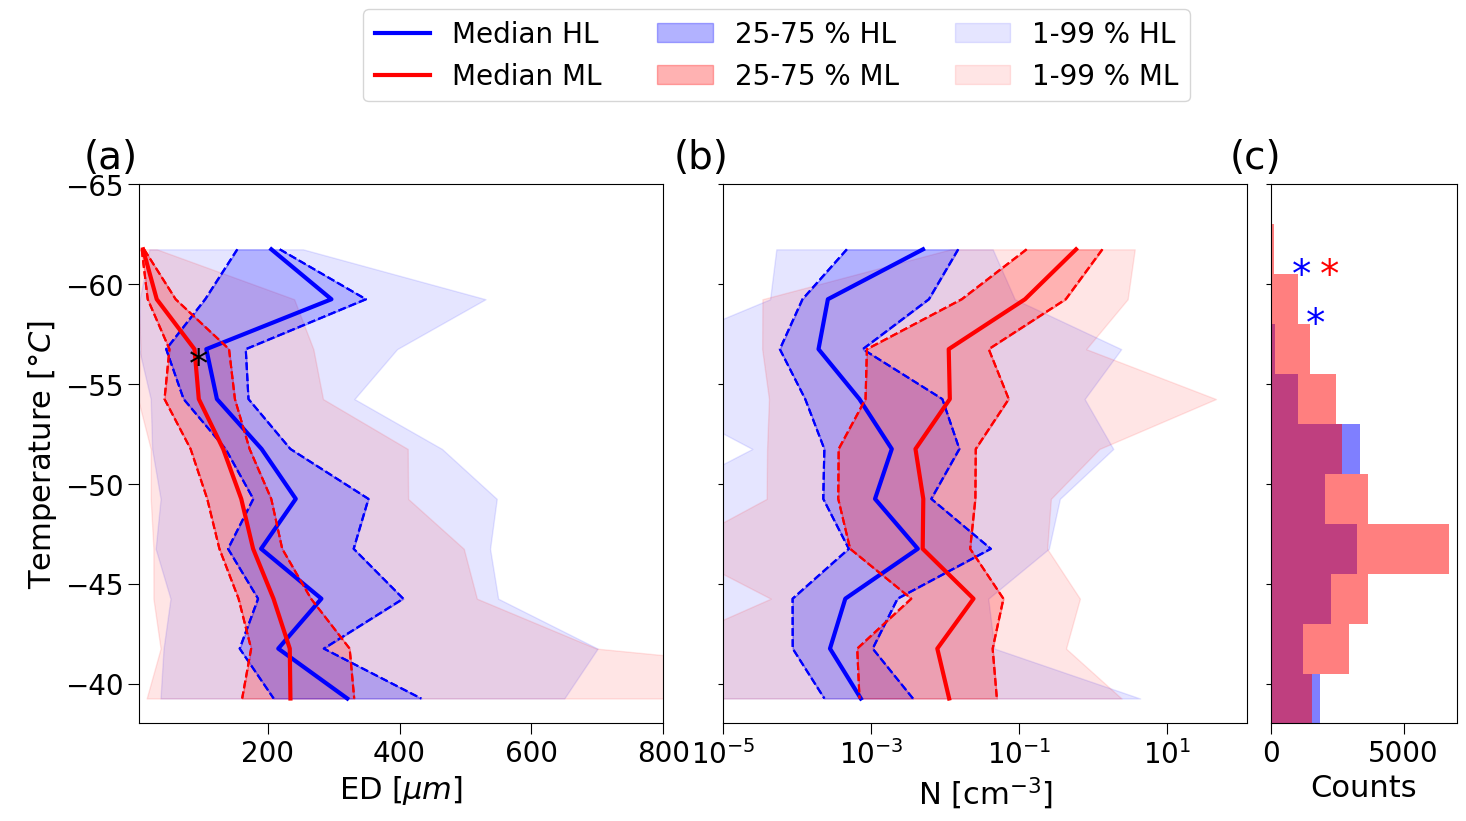

In [35]:
fig = plt.figure(figsize=(17,7))
gs = GridSpec(1,3, wspace=0.15, width_ratios=[7, 7, 2])
ax = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax)
gs2 = GridSpec(1,3, wspace=0.04, width_ratios = [6.5, 6.5, 2.2])
ax3 = fig.add_subplot(gs2[0, 2], sharey=ax)

northed = campaign[(campaign.lat_o_is >= 60)&(campaign.ED_0_is > 2)][['ED_0_is', 'Ts_is']]
northn = campaign[(campaign.lat_o_is >= 60)&(campaign.ED_0_is > 2)][['N_0_is', 'Ts_is']]
southed = campaign[(campaign.lat_o_is < 60)&(campaign.ED_0_is > 2)][['ED_0_is', 'Ts_is']]
southn = campaign[(campaign.lat_o_is < 60)&(campaign.ED_0_is > 2)][['N_0_is', 'Ts_is']]

hbins = np.linspace(-63, -38, 11)
hmidbins = (hbins[:-1]+hbins[1:])/2
hmidbins = [x for x in hmidbins]

ax3.hist(northed.Ts_is, bins=hbins, color='blue', alpha=0.5, orientation='horizontal')
ax3.hist(southed.Ts_is, bins=hbins, color='red', alpha=0.5, orientation='horizontal')

northed['Ts_is'] = pd.cut(northed['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)
southed['Ts_is'] = pd.cut(southed['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)
northn['Ts_is'] = pd.cut(northn['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)
southn['Ts_is'] = pd.cut(southn['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)

#northed = northed.loc[northed.Ts_is <12750]
#northn = northn.loc[northn.Ts_is <12750]

data_df = pd.DataFrame({'ed_n_med':northed.groupby('Ts_is').median().values.flatten(), 'ed_s_med':southed.groupby('Ts_is').median().values.flatten(),
                        'n_n_med':northn.groupby('Ts_is').median().values.flatten(), 'n_s_med':southn.groupby('Ts_is').median().values.flatten(),
                        'ed_n_75':northed.groupby('Ts_is').quantile(q=0.75).values.flatten(), 'ed_s_75':southed.groupby('Ts_is').quantile(q=0.75).values.flatten(),
                       'n_n_75':northn.groupby('Ts_is').quantile(q=0.75).values.flatten(), 'n_s_75':southn.groupby('Ts_is').quantile(q=0.75).values.flatten(),
                        'ed_n_25':northed.groupby('Ts_is').quantile(q=0.25).values.flatten(), 'ed_s_25':southed.groupby('Ts_is').quantile(q=0.25).values.flatten(),
                        'n_n_25':northn.groupby('Ts_is').quantile(q=0.25).values.flatten(), 'n_s_25':southn.groupby('Ts_is').quantile(q=0.25).values.flatten(),
                       'ed_n_100':northed.groupby('Ts_is').quantile(q=0.99).values.flatten(), 'ed_s_100':southed.groupby('Ts_is').quantile(q=0.99).values.flatten(),
                       'n_n_100':northn.groupby('Ts_is').quantile(q=0.99).values.flatten(), 'n_s_100':southn.groupby('Ts_is').quantile(q=0.99).values.flatten(),
                        'ed_n_0':northed.groupby('Ts_is').quantile(q=0.01).values.flatten(), 'ed_s_0':southed.groupby('Ts_is').quantile(q=0.01).values.flatten(),
                        'n_n_0':northn.groupby('Ts_is').quantile(q=0.01).values.flatten(), 'n_s_0':southn.groupby('Ts_is').quantile(q=0.01).values.flatten()}, index=hmidbins)


ax.set_ylim(-38, -65)
ax.set_xlim(5, 800)
ax2.set_xscale('log')
ax2.set_xlim(1e-5, 1.2e2)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
ax.set_ylabel(r'Temperature $[°C]$', fontsize=22)
ax.set_xlabel(r'ED $[µm]$', fontsize=22)
ax2.set_xlabel(r'N $[\mathrm{cm^{-3}}]$', fontsize=22)
ax3.set_xlabel(r'Counts', fontsize=22)
ax3.set_xlim(0, 7000)
ax.tick_params(axis='both', which='major', labelsize=20, length=8)
ax2.tick_params(axis='x', which='major', labelsize=20, length=8)
ax2.tick_params(axis='x', which='minor', labelsize=20, length=4)
ax3.tick_params(axis='x', which='major', labelsize=20, length=8)

ax.plot(data_df.ed_n_med, data_df.index, color='blue', linewidth=3)
ax.plot(data_df.ed_n_75, data_df.index, '--', color='blue', linewidth=1.5)
ax.plot(data_df.ed_n_75, data_df.index, '--', color='blue', linewidth=1.5)
ax.plot(data_df.ed_n_25, data_df.index, '--', color='blue', linewidth=1.5)
ax.plot(data_df.ed_n_25, data_df.index, '--', color='blue', linewidth=1.5)
ax.fill_betweenx(hmidbins, data_df.ed_n_100, data_df.ed_n_75, color='blue', edgecolor='blue', alpha=.1)
ax.fill_betweenx(hmidbins, data_df.ed_n_25, data_df.ed_n_0, color='blue', edgecolor='blue', alpha=.1)


ax.plot(data_df.ed_s_med, data_df.index, color='red', linewidth=3)
ax.plot(data_df.ed_s_75, data_df.index, '--', color='red', linewidth=1.5)
ax.plot(data_df.ed_s_75, data_df.index, '--', color='red', linewidth=1.5)
ax.plot(data_df.ed_s_25, data_df.index, '--', color='red', linewidth=1.5)
ax.plot(data_df.ed_s_25, data_df.index, '--', color='red', linewidth=1.5)
ax.fill_betweenx(hmidbins, data_df.ed_s_100, data_df.ed_s_75, color='red', edgecolor='red', alpha=0.1)
ax.fill_betweenx(hmidbins, data_df.ed_s_25, data_df.ed_s_0, color='red', edgecolor='red', alpha=.1)
ax.fill_betweenx(hmidbins, data_df.ed_s_75, data_df.ed_s_25, color='red', alpha=.3)
ax.fill_betweenx(hmidbins, data_df.ed_n_75, data_df.ed_n_25, color='blue', alpha=.3)

ax2.plot(data_df.n_n_med, data_df.index, color='blue', linewidth=3, label='Median HL')
ax2.plot(data_df.n_n_75, data_df.index, '--', color='blue', linewidth=1.5)
ax2.plot(data_df.n_n_75, data_df.index, '--', color='blue', linewidth=1.5)
ax2.plot(data_df.n_n_25, data_df.index, '--', color='blue', linewidth=1.5)
ax2.plot(data_df.n_n_25, data_df.index, '--', color='blue', linewidth=1.5)
ax2.fill_betweenx(hmidbins, data_df.n_n_100, data_df.n_n_75, color='blue', edgecolor='blue', alpha=.1, label='1-99 % HL')
ax2.fill_betweenx(hmidbins, data_df.n_n_25, data_df.n_n_0, color='blue', edgecolor='blue', alpha=.1)


ax2.plot(data_df.n_s_med, data_df.index, color='red', linewidth=3, label='Median ML')
ax2.plot(data_df.n_s_75, data_df.index, '--', color='red', linewidth=1.5)
ax2.plot(data_df.n_s_75, data_df.index, '--', color='red', linewidth=1.5)
ax2.plot(data_df.n_s_25, data_df.index, '--', color='red', linewidth=1.5)
ax2.plot(data_df.n_s_25, data_df.index, '--', color='red', linewidth=1.5)
ax2.fill_betweenx(hmidbins, data_df.n_s_100, data_df.n_s_75, color='red', edgecolor='red', alpha=0.1, label='1-99 % ML')
ax2.fill_betweenx(hmidbins, data_df.n_s_25, data_df.n_s_0, color='red', edgecolor='red', alpha=.1)
ax2.fill_betweenx(hmidbins, data_df.n_n_75, data_df.n_n_25, color='blue', alpha=.3, label='25-75 % HL')
ax2.fill_betweenx(hmidbins, data_df.n_s_75, data_df.n_s_25, color='red', alpha=.3, label='25-75 % ML')
ax.annotate('(a)', xy=(60, 470), xycoords='figure points', fontsize=28)
ax2.annotate('(b)', xy=(485, 470), xycoords='figure points', fontsize=28)
ax3.annotate('(c)', xy=(885, 470), xycoords='figure points', fontsize=28)
ax.annotate('*', xy=(136, 320), xycoords='figure points', fontsize=28)
ax3.annotate('*', xy=(930, 385), xycoords='figure points', fontsize=28, color='blue')
ax3.annotate('*', xy=(950, 385), xycoords='figure points', fontsize=28, color='red')
ax3.annotate('*', xy=(940, 350), xycoords='figure points', fontsize=28, color='blue')


handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend([handles2[0], handles2[1], handles2[4], handles2[5], handles2[2], handles2[3]],
           [labels2[0], labels2[1], labels2[4], labels2[5], labels2[2], labels2[3]],
           bbox_to_anchor=(0.5,1.15), loc='upper center', fontsize=20, ncol=3)

In [36]:
northed['Ts_is'] = pd.cut(northed['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)
southed['Ts_is'] = pd.cut(southed['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)
northn['Ts_is'] = pd.cut(northn['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)
southn['Ts_is'] = pd.cut(southn['Ts_is'] ,
                   bins=hbins, labels=hmidbins, include_lowest=True)

In [37]:
data_test_ed = np.empty((len(hmidbins), 3))
data_test_n = np.empty((len(hmidbins), 3))

for i, ts in enumerate(hmidbins):
    ed_sample1 = northed[northed.Ts_is == ts].ED_0_is
    ed_sample2 = southed[southed.Ts_is == ts].ED_0_is
    n_sample1 = northn[northn.Ts_is == ts].N_0_is
    n_sample2 = southn[southn.Ts_is == ts].N_0_is
    
    stat1, p1 = mannwhitneyu(ed_sample1, ed_sample2)
    stat2, p2 = mannwhitneyu(n_sample1, n_sample2)
    
    data_test_ed[i, 0] = p1
    data_test_n[i, 0] = p2
    data_test_ed[i, 1] = len(ed_sample1)
    data_test_ed[i, 2] = len(ed_sample2)
    data_test_n[i, 1] = len(n_sample1)
    data_test_n[i, 2] = len(n_sample2)
    
testmw_ed_df = pd.DataFrame(data_test_ed, columns=['pvalue', 'lenHL', 'lenML'])
testmw_n_df = pd.DataFrame(data_test_n, columns=['pvalue', 'lenHL', 'lenML'])

In [38]:
testmw_ed_df

,pvalue,lenHL,lenML
0,3.572184e-12,22.0,119.0
1,4.189623e-12,40.0,1017.0
2,2.200359e-02,146.0,1490.0
3,9.342896e-27,1019.0,2442.0
4,4.767956e-187,3351.0,2677.0
5,3.941268e-211,2055.0,3660.0
6,4.993092e-42,3247.0,6716.0
7,5.510368e-95,2255.0,3649.0
8,1.220903e-06,1208.0,2950.0
9,4.658049e-31,1842.0,1550.0


In [39]:
testmw_n_df

,pvalue,lenHL,lenML
0,1.738288e-12,22.0,119.0
1,1.346074e-14,40.0,1017.0
2,5.225790e-31,146.0,1490.0
3,2.609464e-65,1019.0,2442.0
4,6.910815e-18,3351.0,2677.0
5,1.060785e-49,2055.0,3660.0
6,9.228425e-06,3247.0,6716.0
7,0.000000e+00,2255.0,3649.0
8,3.325246e-174,1208.0,2950.0
9,6.084059e-70,1842.0,1550.0


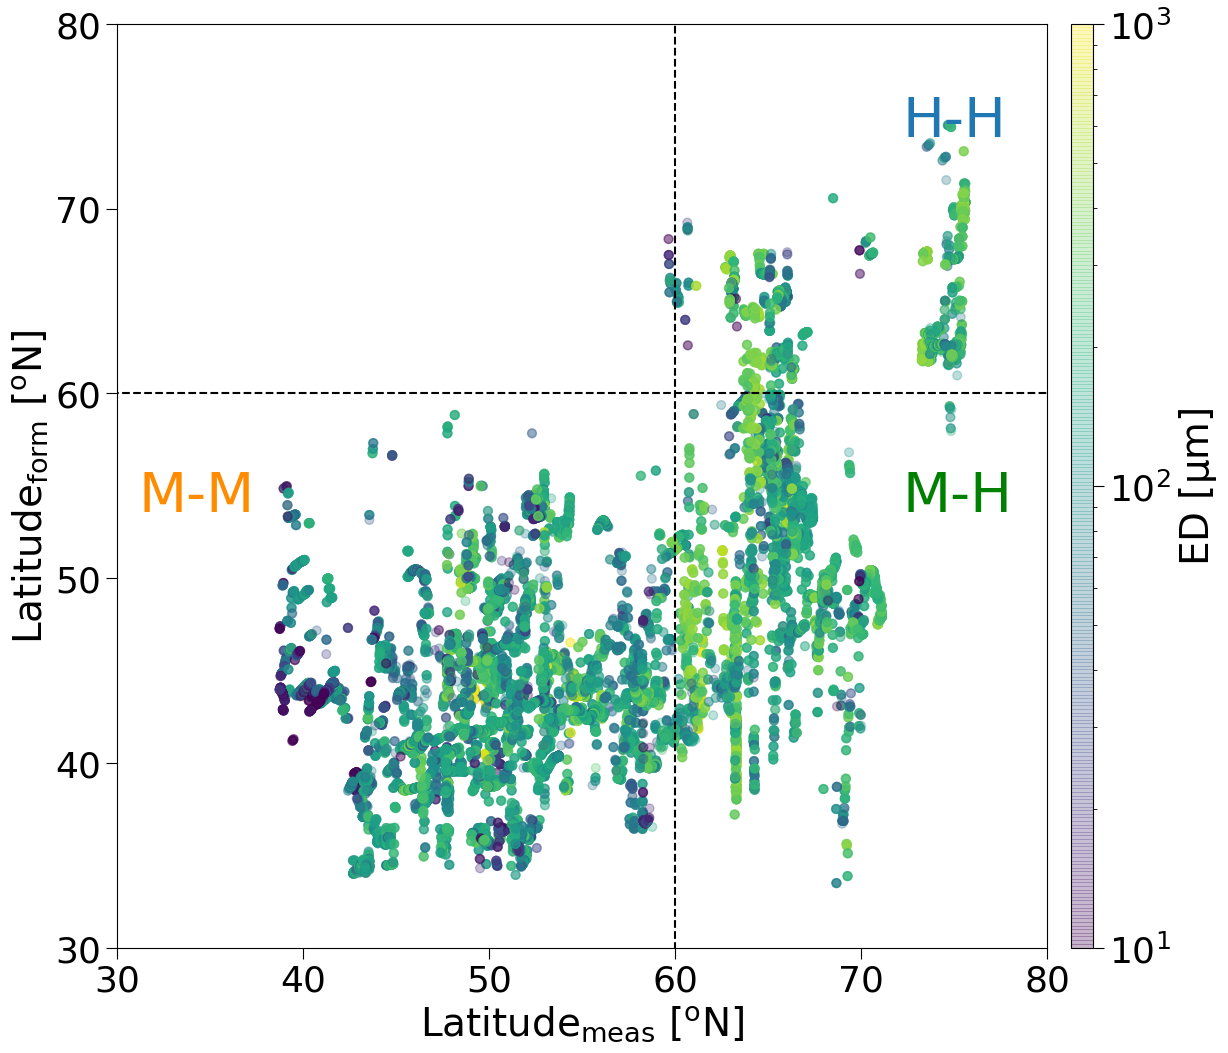

In [40]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

t = [1e0, 1e1, 1e2, 1e3]
norm = colors.LogNorm(vmin=10, vmax=1e3)
orig_map=plt.cm.get_cmap('viridis')

sc = ax.scatter(campaign.lat_o_is, campaign.lat_f, c=campaign.ED_0_is, cmap=orig_map, norm=norm, alpha=0.3, s=40)
ax.hlines(60, 0, 80, linestyle='dashed', color='k')
ax.vlines(60, 0, 80, linestyle='dashed', color='k')

ax.set_xlim(30, 80)
ax.set_ylim(30, 80)
ax.set_xlabel('$\mathrm{Latitude_{meas} \ [^{o}N}$]', fontsize=28)
ax.set_ylabel('$\mathrm{Latitude_{form} \ [^{o}N}$]', fontsize=28)
ax.tick_params(axis='both', which='major', length=8, labelsize=26)

pos0 = ax.get_position()

cbar_ax = fig.add_axes([0.92, pos0.y0, 0.018, pos0.height])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=t)
cbar.set_label('ED [$\mathrm{\mu m}$]', fontsize=28)
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.tick_params(axis='y', which='major', length=8, labelsize=26)
cbar_ax.tick_params(axis='y', which='minor', length=3)

ax.annotate('H-H', color='C0', xy=(650, 660), xycoords='figure points', fontsize=40)
ax.annotate('M-H', color='green', xy=(650, 390), xycoords='figure points', fontsize=40)
ax.annotate('M-M', color='darkorange', xy=(100, 390), xycoords='figure points', fontsize=40)

plt.show()

In [8]:
print('mean ED:', campaign.ED_0_is.median())
print('mean N:', campaign.N_0_is.median())
ED_med_tot = campaign.ED_0_is.median()
N_med_tot = campaign.N_0_is.median()
IWC_med_tot = campaign.IWC_0_is.median()

mean ED: 180.08581902120613
mean N: 0.003958139143679436


In [42]:
ED_med_ml = campaign[campaign.lat_o_is < 60].ED_0_is.median()
N_med_ml = campaign[campaign.lat_o_is < 60].N_0_is.median()
ED_med_hl = campaign[campaign.lat_o_is >= 60].ED_0_is.median()
N_med_hl = campaign[campaign.lat_o_is >= 60].N_0_is.median()

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: Log scale: values of z <= 0 have been masked
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:69: UserWarning: Log scale: values of z <= 0 have been masked
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: UserWarning: Log scale: values of z <= 0 have been masked
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:129: UserWarning: Log scale: values of z <= 0 have been masked


Text(750, 370, '14876 Counts')

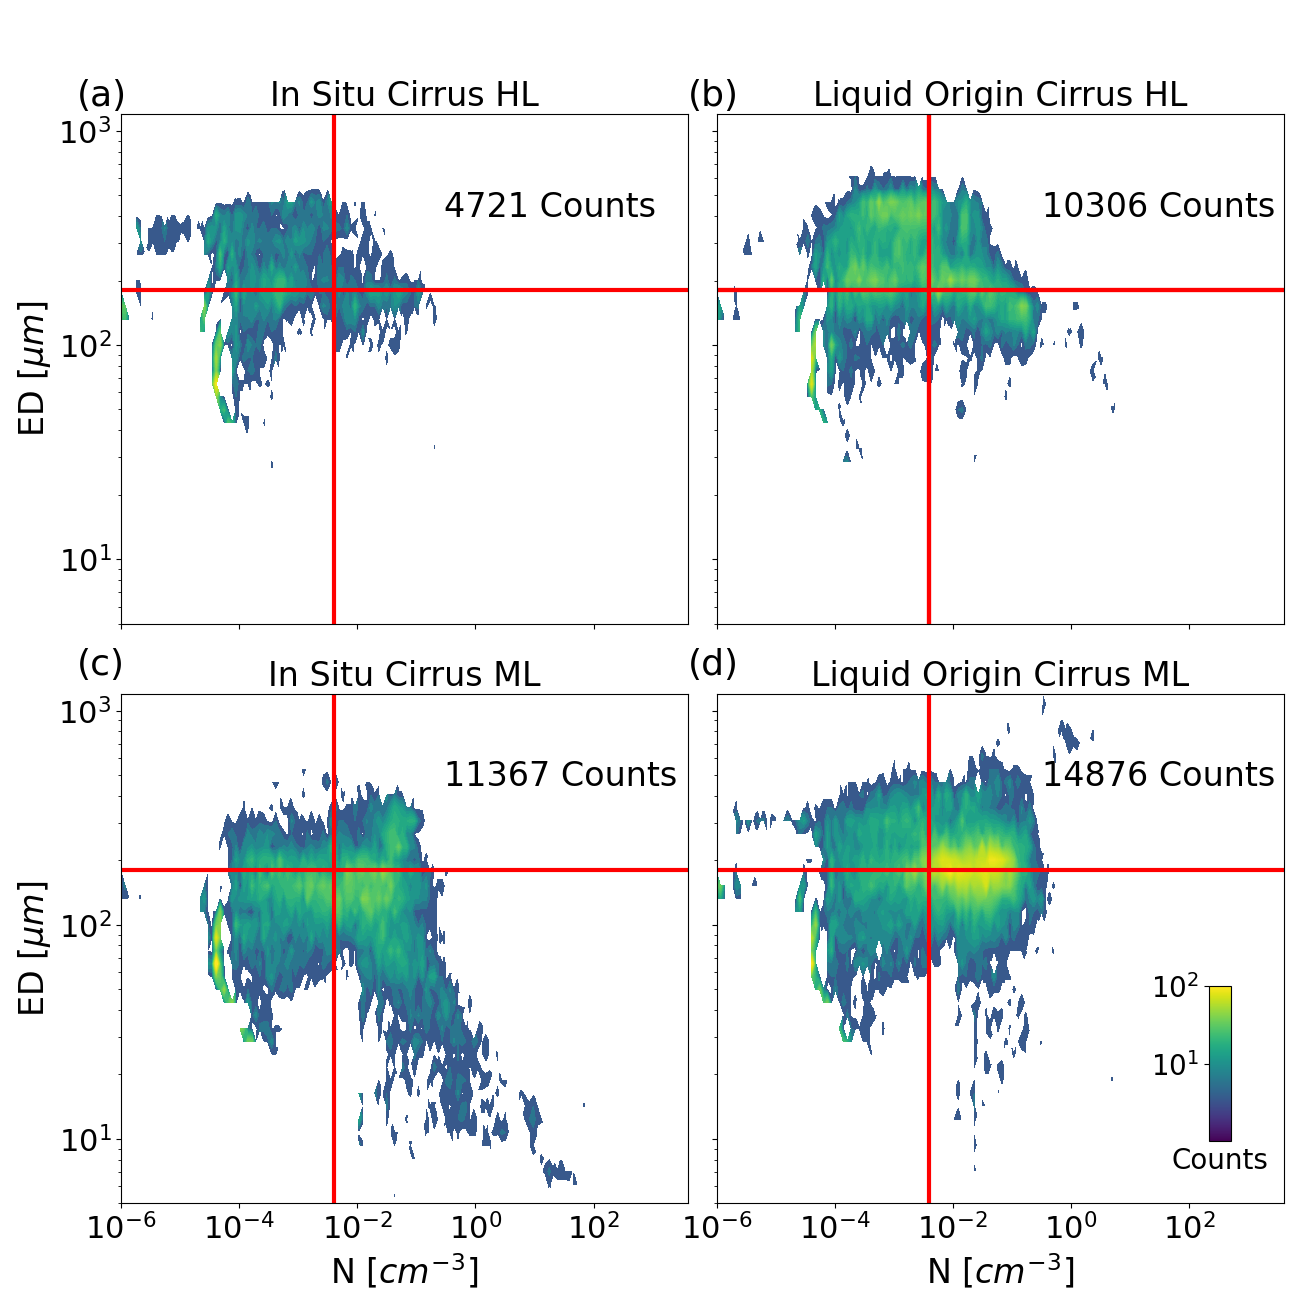

In [43]:
import numpy.ma as ma
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15,15.5))
gs = GridSpec(3,2, wspace=0.05, hspace=0.2, height_ratios=[0.5, 7.5, 7.5])

axt = fig.add_subplot(gs[0, 0:1])
ax_level = fig.add_subplot(gs[1, 0])
ax_level2 = fig.add_subplot(gs[1, 1])
ax_level3 = fig.add_subplot(gs[2, 0])
ax_level4 = fig.add_subplot(gs[2, 1])

plot = campaign[(campaign.type == 1)&(campaign.lat_o_is >= 60)] # in situ HL
len_HLins = len(plot)

xedges = np.logspace(-6, 4, num=150, endpoint=True)
    
yedges = np.logspace(-2, 4, num=100)
H, x, y =np.histogram2d(plot.N_0_is, plot.ED_0_is, bins=(xedges, yedges))

Hm = ma.masked_where(np.isnan(H), H)
Hm = np.where(Hm > 300, 300, Hm)

X, Y = np.meshgrid(xedges, yedges)

norm = colors.LogNorm(vmin=1, vmax=100)

levels = MaxNLocator(nbins=120).tick_values(1, 300)
cf = ax_level.contourf(X[:-1, :-1], Y[:-1, :-1], Hm.transpose(), levels=levels, cmap='viridis', norm=norm)
ax_level.set_xscale('log')
ax_level.set_yscale('log')
ax_level.set_ylim(5, 1200)
ax_level.set_xlim(1e-6, 4000)
ax_level.set_title('In Situ Cirrus HL', fontsize=24)

plt.setp(ax_level.get_xticklabels(), visible=False)
ax_level.set_ylabel('ED [$\mu m$]', fontsize=24)
ax_cbar = fig.add_axes([0.85, 0.15, 0.015, 0.1])
ax_level.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)
ax_level2.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level2.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level.tick_params(axis='both', which='major', labelsize=22)

# colorbar
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), cax=ax_cbar, ticks=[1e1, 1e2])
ax_cbar.yaxis.set_ticks_position('left')
ax_cbar.tick_params(axis='both', which='major', labelsize=20)
ax_cbar.set_xlabel('Counts', fontsize=20)

########################

plot = campaign[(campaign.type == 0)&(campaign.lat_o_is >= 60)] # liquid HL
len_HLliq = len(plot)

xedges = np.logspace(-6, 4, num=150, endpoint=True)
    
yedges = np.logspace(-2, 4, num=100)
H, x, y =np.histogram2d(plot.N_0_is, plot.ED_0_is, bins=(xedges, yedges))

Hm = ma.masked_where(np.isnan(H), H)
Hm = np.where(Hm > 300, 300, Hm)

X, Y = np.meshgrid(xedges, yedges)

levels = MaxNLocator(nbins=120).tick_values(1, 300)
cf = ax_level2.contourf(X[:-1, :-1], Y[:-1, :-1], Hm.transpose(), levels=levels, cmap='viridis', norm=norm)
ax_level2.set_xscale('log')
ax_level2.set_yscale('log')
ax_level2.set_ylim(5, 1200)
ax_level2.set_xlim(1e-6, 4000)
ax_level2.set_title('Liquid Origin Cirrus HL', fontsize=24)

plt.setp(ax_level2.get_yticklabels(), visible=False)
plt.setp(ax_level2.get_xticklabels(), visible=False)
ax_level2.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level2.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level2.tick_params(axis='both', which='major', labelsize=22)

#####################################

plot = campaign[(campaign.type == 1)&(campaign.lat_o_is < 60)] # in situ ML
len_MLins = len(plot)

xedges = np.logspace(-6, 4, num=150, endpoint=True)
    
yedges = np.logspace(-2, 4, num=100)
H, x, y =np.histogram2d(plot.N_0_is, plot.ED_0_is, bins=(xedges, yedges))

Hm = ma.masked_where(np.isnan(H), H)
Hm = np.where(Hm > 300, 300, Hm)

X, Y = np.meshgrid(xedges, yedges)

levels = MaxNLocator(nbins=120).tick_values(1, 300)
cf = ax_level3.contourf(X[:-1, :-1], Y[:-1, :-1], Hm.transpose(), levels=levels, cmap='viridis', norm=norm)
ax_level3.set_xscale('log')
ax_level3.set_yscale('log')
ax_level3.set_ylim(5, 1200)
ax_level3.set_xlim(1e-6, 4000)
ax_level3.set_xlabel('N [$cm^{-3}$]', fontsize=24)
ax_level3.set_title('In Situ Cirrus ML', fontsize=24)

ax_level3.set_ylabel('ED [$\mu m$]', fontsize=24)
ax_level3.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level3.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level3.tick_params(axis='both', which='major', labelsize=22)

#####################################

plot = campaign[(campaign.type == 0)&(campaign.lat_o_is < 60)] # liquid HL
len_MLliq = len(plot)

xedges = np.logspace(-6, 4, num=150, endpoint=True)
    
yedges = np.logspace(-2, 4, num=100)
H, x, y =np.histogram2d(plot.N_0_is, plot.ED_0_is, bins=(xedges, yedges))

Hm = ma.masked_where(np.isnan(H), H)
Hm = np.where(Hm > 300, 300, Hm)

X, Y = np.meshgrid(xedges, yedges)

levels = MaxNLocator(nbins=120).tick_values(1, 300)
cf = ax_level4.contourf(X[:-1, :-1], Y[:-1, :-1], Hm.transpose(), levels=levels, cmap='viridis', norm=norm)
ax_level4.set_xscale('log')
ax_level4.set_yscale('log')
ax_level4.set_ylim(5, 1200)
ax_level4.set_xlim(1e-6, 4000)
ax_level4.set_xlabel('N [$cm^{-3}$]', fontsize=24)
ax_level4.set_title('Liquid Origin Cirrus ML', fontsize=24)

plt.setp(ax_level4.get_yticklabels(), visible=False)
ax_level4.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level4.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level4.tick_params(axis='both', which='major', labelsize=22)

axt.axis('off')
ax_level.annotate('(a)', xy=(55, 860), xycoords='figure points', fontsize=26)
ax_level2.annotate('(b)', xy=(495, 860), xycoords='figure points', fontsize=26)
ax_level3.annotate('(c)', xy=(55, 450), xycoords='figure points', fontsize=26)
ax_level4.annotate('(d)', xy=(495, 450), xycoords='figure points', fontsize=26)

ax_level.annotate(str(len_HLins) + ' Counts', xy=(320, 780), xycoords='figure points', fontsize=24)
ax_level2.annotate(str(len_HLliq) + ' Counts', xy=(750, 780), xycoords='figure points', fontsize=24)
ax_level3.annotate(str(len_MLins) + ' Counts', xy=(320, 370), xycoords='figure points', fontsize=24)
ax_level4.annotate(str(len_MLliq) + ' Counts', xy=(750, 370), xycoords='figure points', fontsize=24)

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log
  
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log


Text(520, 420, '(b)')

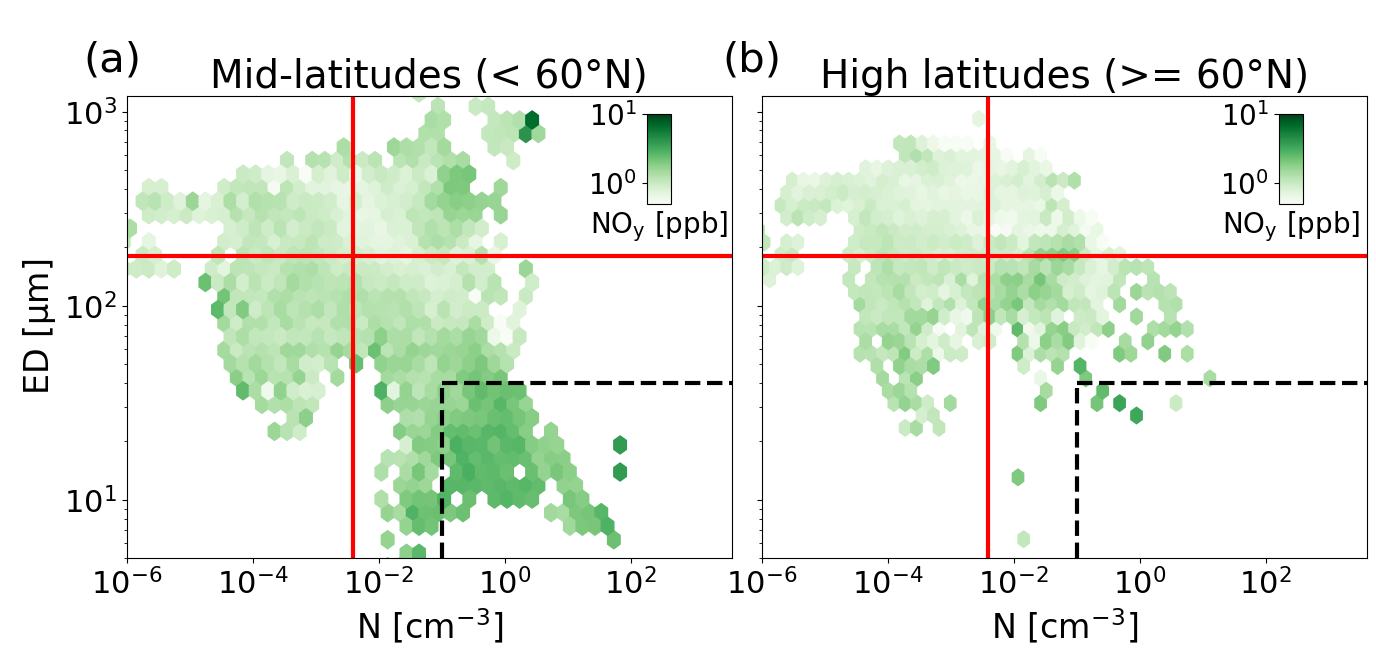

In [78]:
import numpy.ma as ma
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,6))
gs = GridSpec(1,2, wspace=0.05)

ax_level = fig.add_subplot(gs[0, 0])
ax_level2 = fig.add_subplot(gs[0, 1])

plot = campaign[(campaign.NOy>0)&(campaign.NO>0)&(campaign.lat_o_is<60)]

norm = colors.LogNorm(vmin=0.5, vmax=10)

cf = ax_level.hexbin( x= plot.N_0_is, y= plot.ED_0_is, C= plot.NOy, bins='log', yscale='log', xscale='log',
                         cmap = 'Greens', gridsize=40, norm=norm, mincnt=2)

ax_cbar = fig.add_axes([0.45, 0.7, 0.015, 0.15])
fig.colorbar(cf, cax=ax_cbar, ticks=[1e-1, 1e0, 1e1])
ax_cbar.yaxis.set_ticks_position('left')
ax_cbar.tick_params(axis='both', which='major', labelsize=20)
ax_cbar.set_xlabel('NO$_\mathrm{y}$ [ppb]', fontsize=20)

plot = campaign[(campaign.NOy>0)&(campaign.NO>0)&(campaign.lat_o_is>=60)]

cf = ax_level2.hexbin( x= plot.N_0_is, y= plot.ED_0_is, C= plot.NOy, bins='log', yscale='log', xscale='log',
                         cmap = 'Greens', gridsize=40, norm=norm, mincnt=2)

ax_level.set_xscale('log')
ax_level.set_yscale('log')
ax_level.set_ylim(5, 1200)
ax_level.set_xlim(1e-6, 4000)

ax_level2.set_xscale('log')
ax_level2.set_yscale('log')
ax_level2.set_ylim(5, 1200)
ax_level2.set_xlim(1e-6, 4000)

plt.setp(ax_level2.get_yticklabels(), visible=False)

ax_level.set_ylabel('ED [$\mathrm{\mu m}$]', fontsize=24)
ax_level.set_xlabel('N [$\mathrm{cm^{-3}}$]', fontsize=24)
ax_level2.set_xlabel('N [$\mathrm{cm^{-3}}$]', fontsize=24)
ax_cbar = fig.add_axes([0.845, 0.7, 0.015, 0.15])
ax_level.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level.hlines(40, 0.1, 1e4, colors='black', linewidth=3, linestyle='dashed')
ax_level.vlines(0.1, 5, 40, colors='black', linewidth=3, linestyle='dashed')

ax_level2.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level2.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level2.hlines(40, 0.1, 1e4, colors='black', linewidth=3, linestyle='dashed')
ax_level2.vlines(0.1, 5, 40, colors='black', linewidth=3, linestyle='dashed')

ax_level.tick_params(axis='both', which='major', labelsize=22)
ax_level2.tick_params(axis='both', which='major', labelsize=22)

ax_level.set_title('Mid-latitudes (< 60°N)', fontsize=28)
ax_level2.set_title('High latitudes (>= 60°N)', fontsize=28)

# colorbar
fig.colorbar(cf, cax=ax_cbar, ticks=[1e-1, 1e0, 1e1])
ax_cbar.yaxis.set_ticks_position('left')
ax_cbar.tick_params(axis='both', which='major', labelsize=20)
ax_cbar.set_xlabel('NO$_\mathrm{y}$ [ppb]', fontsize=20)

ax_level.annotate('(a)', xy=(60, 420), xycoords='figure points', fontsize=30)
ax_level2.annotate('(b)', xy=(520, 420), xycoords='figure points', fontsize=30)

C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log
  
C:\Users\dela_el\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log


Text(520, 420, '(d)')

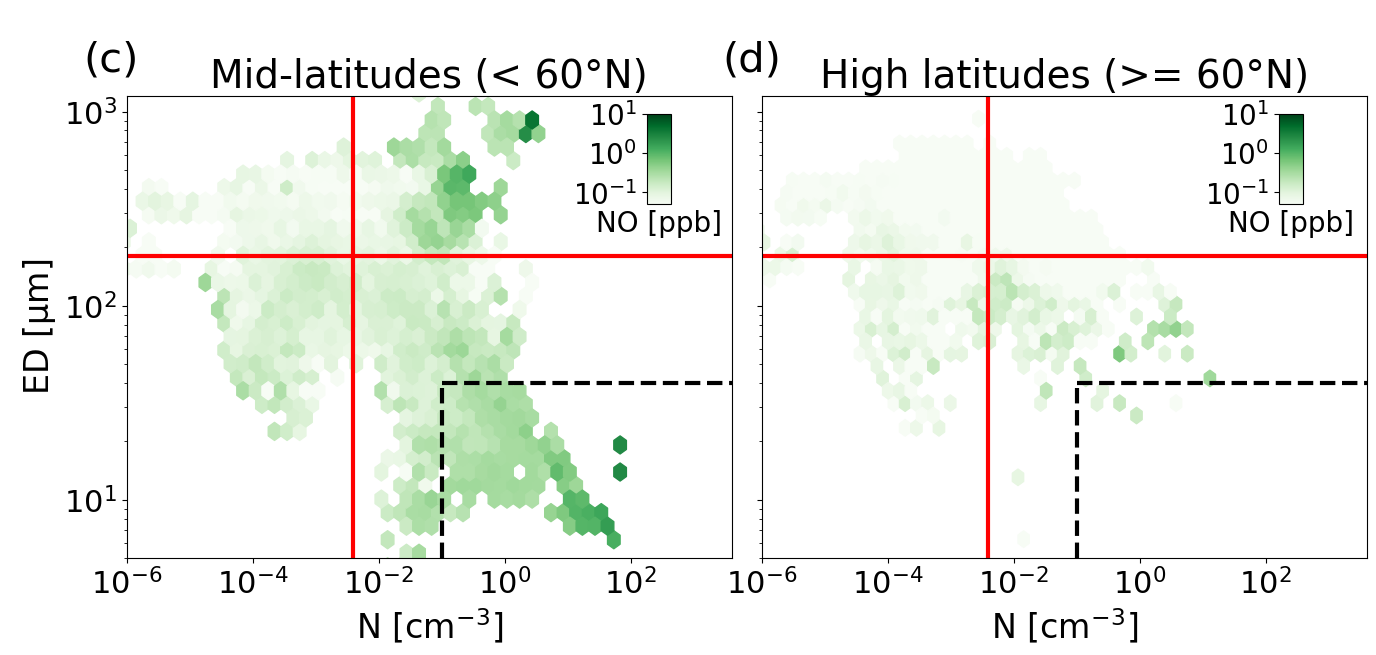

In [80]:
import numpy.ma as ma
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,6))
gs = GridSpec(1,2, wspace=0.05)

ax_level = fig.add_subplot(gs[0, 0])
ax_level2 = fig.add_subplot(gs[0, 1])

plot = campaign[(campaign.NOy>0)&(campaign.NO>0)&(campaign.lat_o_is<60)]

norm = colors.LogNorm(vmin=0.05, vmax=10)

cf = ax_level.hexbin( x= plot.N_0_is, y= plot.ED_0_is, C= plot.NO, bins='log', yscale='log', xscale='log',
                         cmap = 'Greens', gridsize=40, norm=norm, mincnt=2)

ax_cbar = fig.add_axes([0.45, 0.7, 0.015, 0.15])
fig.colorbar(cf, cax=ax_cbar, ticks=[1e-1, 1e0, 1e1])
ax_cbar.yaxis.set_ticks_position('left')
ax_cbar.tick_params(axis='both', which='major', labelsize=20)
ax_cbar.set_xlabel('NO [ppb]', fontsize=20)

plot = campaign[(campaign.NOy>0)&(campaign.NO>0)&(campaign.lat_o_is>=60)]

cf = ax_level2.hexbin( x= plot.N_0_is, y= plot.ED_0_is, C= plot.NO, bins='log', yscale='log', xscale='log',
                         cmap = 'Greens', gridsize=40, norm=norm, mincnt=2)

ax_level.set_xscale('log')
ax_level.set_yscale('log')
ax_level.set_ylim(5, 1200)
ax_level.set_xlim(1e-6, 4000)

ax_level2.set_xscale('log')
ax_level2.set_yscale('log')
ax_level2.set_ylim(5, 1200)
ax_level2.set_xlim(1e-6, 4000)

plt.setp(ax_level2.get_yticklabels(), visible=False)

ax_level.set_ylabel('ED [$\mathrm{\mu m}$]', fontsize=24)
ax_level.set_xlabel('N [$\mathrm{cm^{-3}}$]', fontsize=24)
ax_level2.set_xlabel('N [$\mathrm{cm^{-3}}$]', fontsize=24)
ax_cbar = fig.add_axes([0.845, 0.7, 0.015, 0.15])
ax_level.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level.hlines(40, 0.1, 1e4, colors='black', linewidth=3, linestyle='dashed')
ax_level.vlines(0.1, 5, 40, colors='black', linewidth=3, linestyle='dashed')

ax_level2.hlines(ED_med_tot, 1e-6, 1e4, colors='r', linewidth=3)
ax_level2.vlines(N_med_tot, 5, 1200, colors='r', linewidth=3)

ax_level2.hlines(40, 0.1, 1e4, colors='black', linewidth=3, linestyle='dashed')
ax_level2.vlines(0.1, 5, 40, colors='black', linewidth=3, linestyle='dashed')

ax_level.tick_params(axis='both', which='major', labelsize=22)
ax_level2.tick_params(axis='both', which='major', labelsize=22)

ax_level.set_title('Mid-latitudes (< 60°N)', fontsize=28)
ax_level2.set_title('High latitudes (>= 60°N)', fontsize=28)

# colorbar
fig.colorbar(cf, cax=ax_cbar, ticks=[1e-1, 1e0, 1e1])
ax_cbar.yaxis.set_ticks_position('left')
ax_cbar.tick_params(axis='both', which='major', labelsize=20)
ax_cbar.set_xlabel('NO [ppb]', fontsize=20)

ax_level.annotate('(c)', xy=(60, 420), xycoords='figure points', fontsize=30)
ax_level2.annotate('(d)', xy=(520, 420), xycoords='figure points', fontsize=30)

In situ HL 0.008123490950167107 In situ ML 0.03728837300032923 Liquid HL 0.07885868639979543 Liquid ML 0.10950115220480655


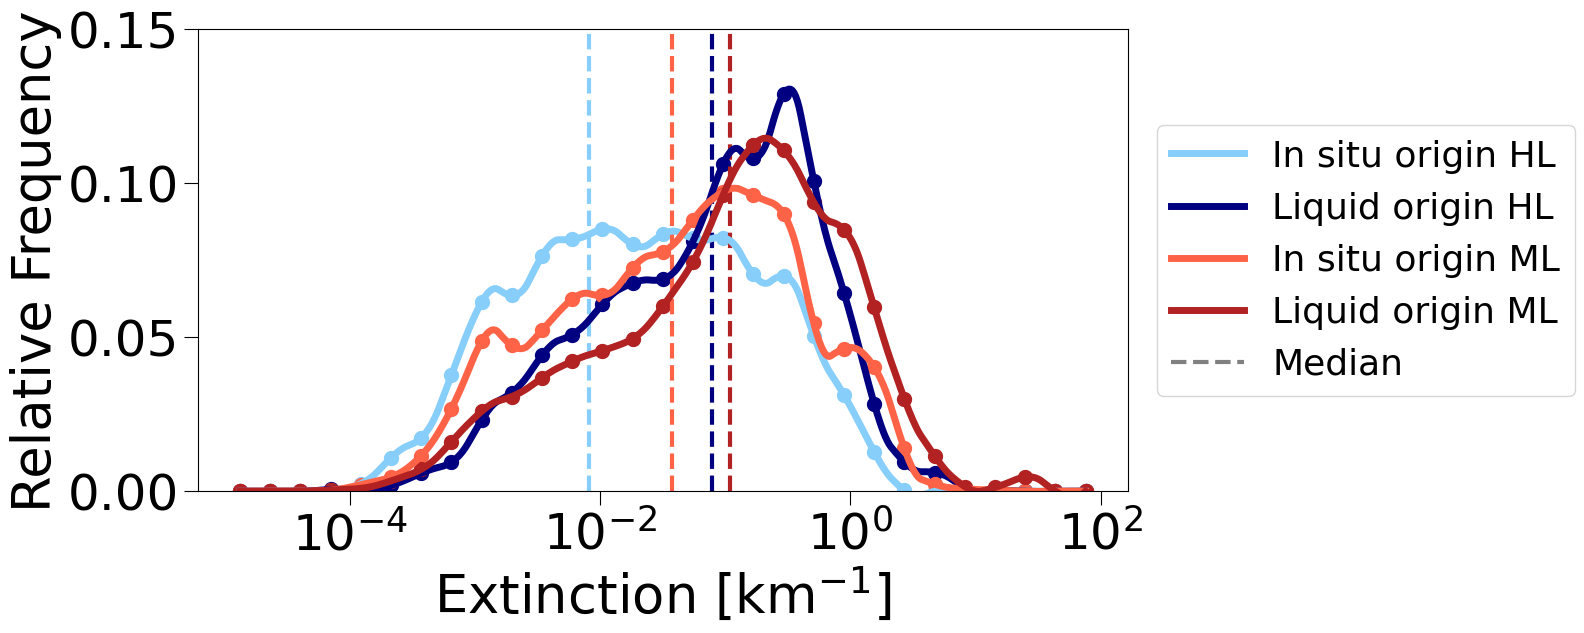

In [44]:
%matplotlib inline

import scipy.interpolate as interpolate
from matplotlib.lines import Line2D

insitu_hl = campaign.loc[(campaign.type == 1) & (campaign.lat_o_is >=60)]
insitu_ml = campaign.loc[(campaign.type == 1) & (campaign.lat_o_is <60)&~((campaign.altitude < 9500)&(campaign.ED_0_is>1000))]
liquid_hl = campaign.loc[(campaign.type == 0) & (campaign.lat_o_is >=60)]
liquid_ml = campaign.loc[(campaign.type == 0) & (campaign.lat_o_is <60)&~((campaign.altitude < 9500)&(campaign.ED_0_is>1000))]

med_ishl = insitu_hl.Ext.median()
med_isml = insitu_ml.Ext.median()
med_liqhl = liquid_hl.Ext.median()
med_liqml = liquid_ml.Ext.median()

print('In situ HL', med_ishl, 'In situ ML', med_isml, 'Liquid HL', med_liqhl, 'Liquid ML', med_liqml)

edges = np.logspace(-5, 2, 30)
mids = 10**((np.log10(edges[:-1]) + np.log10(edges[1:]))/2)

hishl, edges = np.histogram(insitu_hl.Ext, bins=edges)
hisml, edges = np.histogram(insitu_ml.Ext, bins=edges)
hliqhl, edges = np.histogram(liquid_hl.Ext, bins=edges)
hliqml, edges = np.histogram(liquid_ml.Ext, bins=edges)

hishl = hishl/hishl.sum()
hisml = hisml/hisml.sum()
hliqhl = hliqhl/hliqhl.sum()
hliqml = hliqml/hliqml.sum()

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ax.scatter(mids, hishl, c='lightskyblue', linewidth=5)
ax.scatter(mids, hliqhl,  c='navy', linewidth=5)
ax.scatter(mids, hisml, c='tomato', linewidth=5)
ax.scatter(mids, hliqml, c='firebrick', linewidth=5)

N = 500
x = mids
y1 = hishl
y2 = hliqhl
y3 = hisml
y4 = hliqml

xmin, xmax = x.min(), x.max()
xx = np.logspace(np.log10(xmin), np.log10(xmax), N)

t, c, k = interpolate.splrep(x, y1, s=0, k=2)
spline = interpolate.BSpline(t, c, k, extrapolate=False)
ax.plot(xx, spline(xx), 'lightskyblue', label='In situ origin HL', linewidth=5)

t, c, k = interpolate.splrep(x, y2, s=0, k=2)
spline = interpolate.BSpline(t, c, k, extrapolate=False)
ax.plot(xx, spline(xx), label='Liquid origin HL',  c='navy', linewidth=5)

t, c, k = interpolate.splrep(x, y3, s=0, k=2)
spline = interpolate.BSpline(t, c, k, extrapolate=False)
ax.plot(xx, spline(xx), label='In situ origin ML', c='tomato', linewidth=5)

t, c, k = interpolate.splrep(x, y4, s=0, k=2)
spline = interpolate.BSpline(t, c, k, extrapolate=False)
ax.plot(xx, spline(xx), label='Liquid origin ML', c='firebrick', linewidth=5)

ax.vlines(med_ishl, 0, 0.15, color='lightskyblue', linewidth=3, linestyle='dashed')
ax.vlines(med_liqhl, 0, 0.15,  color='navy', linewidth=3, linestyle='dashed')
ax.vlines(med_isml, 0, 0.15, color='tomato', linewidth=3, linestyle='dashed')
ax.vlines(med_liqml, 0, 0.15, color='firebrick', linewidth=3, linestyle='dashed')


ax.tick_params(axis='both', which='major', labelsize=36, length=10)
ax.tick_params(axis='both', which='minor', length=5)
ax.set_xlabel('Extinction [$\mathrm{km}^{-1}$]', fontsize=38)
ax.set_ylabel('Relative Frequency', fontsize=38)

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_ylim(0, 0.15)

custom = Line2D([], [], color='gray', lw=3, linestyle='dashed', label='Median')
handles, labels = ax.get_legend_handles_labels()
handles.append(custom)
labels.append('Median')

ax.legend(handles, labels, bbox_to_anchor=(1.5,0.5), loc='center right', fontsize=26, ncol=1)

Text(690, 630, '(b)')

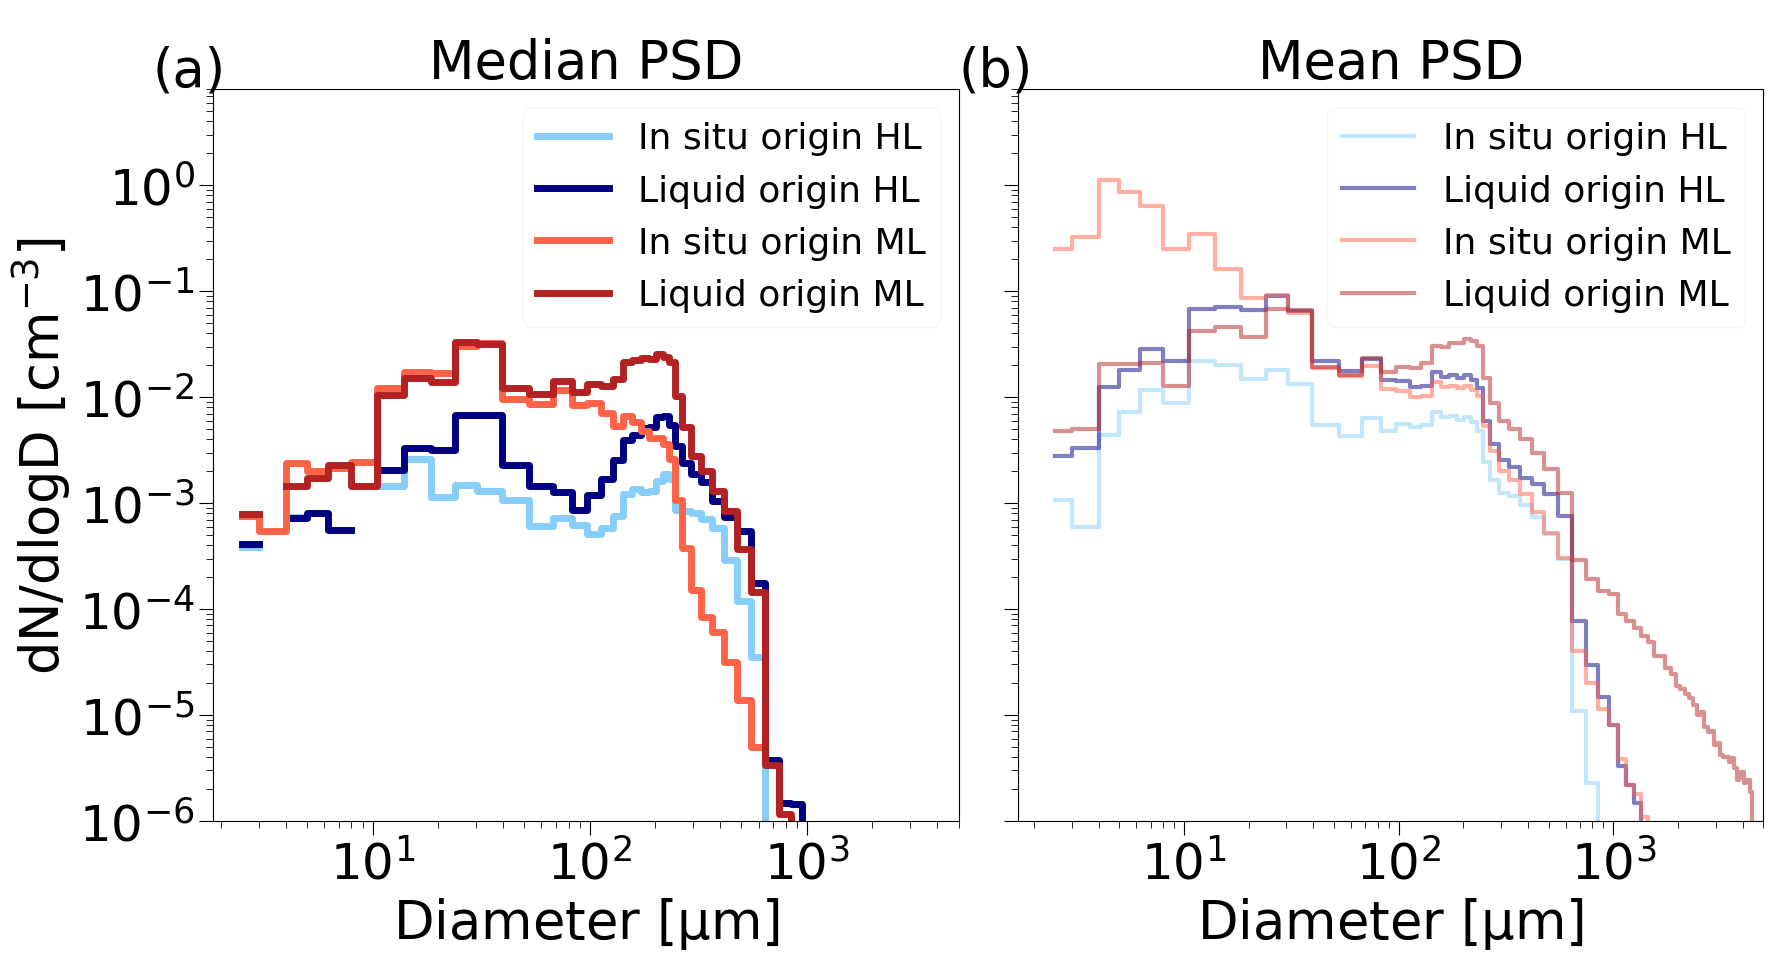

In [45]:
from Utility import get_dNdlogD_mean, get_dNdlogD, get_dNdD
from Data_object import Data, load
import random
from matplotlib.lines import Line2D

def dNdlogD_mean_calc(distribution, bin_df):
	dist = get_dNdlogD(distribution, bin_df)
	dist2 = get_dNdD(distribution)

	dNdlogD_mean = np.zeros(np.shape(dist)[1])
	dNdD_mean = np.zeros(np.shape(dist2)[1])
	variance = np.zeros(np.shape(dist)[1])
	for x in range(len(dist.columns)):
		dNdlogD_mean[x] = dist[dist.columns[x]].mean() * 1e-6
		dNdD_mean[x] = dist2[dist2.columns[x]].mean()
		variance[x] = dist[dist.columns[x]].var()
	
	ED = calc_ED(pd.DataFrame([dNdD_mean, np.zeros(np.shape(dNdD_mean))], columns=dist2.columns), bin_df)[0]*1e6
    
	return dNdlogD_mean, ED

def dNdlogD_median_calc(distribution, bin_df):
	dist = get_dNdlogD(distribution, bin_df)
	dist2 = get_dNdD(distribution)

	dNdlogD_median = np.zeros(np.shape(dist)[1])
	dNdD_median = np.zeros(np.shape(dist2)[1])
	variance = np.zeros(np.shape(dist)[1])
	for x in range(len(dist.columns)):
		dNdlogD_median[x] = dist[dist.columns[x]].median() * 1e-6
		dNdD_median[x] = dist2[dist2.columns[x]].median()
		variance[x] = dist[dist.columns[x]].var()
    
	ED = calc_ED(pd.DataFrame([dNdD_median, np.zeros(np.shape(dNdD_median))], columns=dist2.columns), bin_df)[0]*1e6
	
	return dNdlogD_median, ED

combined = load(''+'/Data/Data_ACP_article/Example_files_combine_probes/Final_combined/F04/CDPCIPGPIP_Combi/')

fig = plt.figure(figsize=(20,9.5))
gs = GridSpec(1, 2, wspace=0.08)
ax = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1], sharey=ax)

ax.set_xscale('log')
ax.set_xlabel('Diameter [$\mathrm{\mu m}$]', fontsize=38)
ax.set_ylabel('dN/dlogD$~[\mathrm{cm^{-3}}]$', fontsize=38)
ax2.set_xscale('log')
ax2.set_xlabel('Diameter [$\mathrm{\mu m}$]', fontsize=38)
cols = [x for x in campaign.columns if 'dNdD_' in x ] + ['N_0_is', 'ED_0_is', 'IWC_0_is', 'altitude', 'lat_o_is', 'lat_f', 'Ts_is', 'type', 'upw_mean']

#liquid_dist = campaign[cols]
dist = campaign[cols]
dist = dist.loc[(dist.N_0_is > 1e-5)&(dist.ED_0_is > 0) & (dist.IWC_0_is > 1e-5)]

type_1 = dist.loc[(dist.type == 1) & (dist.lat_o_is >=60)]
type_2 = dist.loc[(dist.type == 1) & (dist.lat_o_is <60)&~((dist.altitude < 9500)&(dist.ED_0_is>1000))]
type_3 = dist.loc[(dist.type == 0) & (dist.lat_o_is >=60)]
type_4 = dist.loc[(dist.type == 0) & (dist.lat_o_is <60)&~((dist.altitude < 9500)&(dist.ED_0_is>1000))]
    
dNdlogD_mean_1, ED_mean_1 = dNdlogD_mean_calc(type_1, combined.bin_df*1e-6)
dNdlogD_mean_2, ED_mean_2 = dNdlogD_mean_calc(type_2, combined.bin_df*1e-6)
dNdlogD_mean_3, ED_mean_3 = dNdlogD_mean_calc(type_3, combined.bin_df*1e-6)
dNdlogD_mean_4, ED_mean_4 = dNdlogD_mean_calc(type_4, combined.bin_df*1e-6)

origin = 0

type_1.index = np.arange(pd.Timestamp(origin, unit='s'), pd.Timestamp(len(type_1)+origin, unit='s'), 1000000)
type_1 = type_1.resample('180S').mean()

type_2.index = np.arange(pd.Timestamp(origin, unit='s'), pd.Timestamp(len(type_2)+origin, unit='s'), 1000000)
type_2 = type_2.resample('180S').mean()

type_3.index = np.arange(pd.Timestamp(origin, unit='s'), pd.Timestamp(len(type_3)+origin, unit='s'), 1000000)
type_3 = type_3.resample('180S').mean()

type_4.index = np.arange(pd.Timestamp(origin, unit='s'), pd.Timestamp(len(type_4)+origin, unit='s'), 1000000)
type_4 = type_4.resample('180S').mean()

dNdlogD_median_1, ED_med_1 = dNdlogD_median_calc(type_1, combined.bin_df*1e-6)
dNdlogD_median_2, ED_med_2 = dNdlogD_median_calc(type_2, combined.bin_df*1e-6)
dNdlogD_median_3, ED_med_3 = dNdlogD_median_calc(type_3, combined.bin_df*1e-6)
dNdlogD_median_4, ED_med_4 = dNdlogD_median_calc(type_4, combined.bin_df*1e-6)

dNdlogD_median_1[dNdlogD_median_1 == 0] = np.nan
dNdlogD_median_2[dNdlogD_median_2 == 0] = np.nan
dNdlogD_median_3[dNdlogD_median_3 == 0] = np.nan
dNdlogD_median_4[dNdlogD_median_4 == 0] = np.nan

ax.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_median_1, label='In situ origin HL', drawstyle='steps-mid', c='lightskyblue', linewidth=5)
ax.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_median_3, label='Liquid origin HL', drawstyle='steps-mid', c='navy', linewidth=5)
ax.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_median_2, label='In situ origin ML', drawstyle='steps-mid', c='tomato', linewidth=5)
ax.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_median_4, label='Liquid origin ML', drawstyle='steps-mid', c='firebrick', linewidth=5)    

ax2.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_mean_1, label='In situ origin HL', drawstyle='steps-mid', c='lightskyblue', linewidth=3, alpha=.5)
ax2.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_mean_3, label='Liquid origin HL', drawstyle='steps-mid', c='navy', linewidth=3, alpha=.5)
ax2.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_mean_2, label='In situ origin ML', drawstyle='steps-mid', c='tomato', linewidth=3, alpha=.5)
ax2.semilogy(combined.bin_df.bin_mid.to_numpy(), dNdlogD_mean_4, label='Liquid origin ML', drawstyle='steps-mid', c='firebrick', linewidth=3, alpha=.5)          

ax.legend(fontsize=26, framealpha=0.2)
ax2.legend(fontsize=26, framealpha=0.2)
ax.set_ylim(1e-6, 8e0)
ax.set_xlim(right=5e3)
ax2.set_xlim(right=5e3)
ax.set_title('Median PSD', fontsize=38)
ax2.set_title('Mean PSD', fontsize=38)
ax.tick_params(axis='both', which='major', labelsize=36, length=10)
ax.tick_params(axis='both', which='minor', length=5)
ax2.tick_params(axis='both', which='major', labelsize=36, length=10)
ax2.tick_params(axis='both', which='minor', length=5)

plt.setp(ax2.get_yticklabels(), visible=False)

ax.annotate('(a)', xy=(110, 630), xycoords='figure points', fontsize=38)
ax2.annotate('(b)', xy=(690, 630), xycoords='figure points', fontsize=38)